# Exploratory Data Analysis of World Happiness

- Mutluluk endeksi veri seti [kaggle](https://www.kaggle.com/unsdsn/world-happiness)'dan alinmistir.
- Hedef degisken: Happiness Score

---
## ***Data Cleaning***

In [1]:
import pandas as pd
import numpy as np
# grafiksel araclar
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import missingno
# json dosyasina okuma yazma icin
import json
import math
# aykiri degerleri giderme icin
from scipy.stats.mstats import winsorize
# jb test icin
from scipy.stats import jarque_bera
from scipy.stats import normaltest
# ttesti ve anova icin
import scipy.stats as stats
# pca icin
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# uyarilari dikkate alma
import warnings
warnings.filterwarnings('ignore')

# * ile dosya okumak icin
import glob
# path islemleri icin
import os

# pandas varsayilan olarak cok sayida sutun veya satir varsa tumunu gostermez
# bu nedenle 100 sutun ve satir gostermesi icin
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# virgulden sonra belirli sayida basamak gosterimi icin 
pd.options.display.float_format = '{:,.3f}'.format

# font tanimlamalari
title_font = {'family': 'times new roman', 'color': 'darkred','weight': 'bold','size': 14}
axis_font  = {'family': 'times new roman', 'color': 'darkred','weight': 'bold','size': 14}

- Birden fazla dosyadan tek frame e veri yukleme.

In [2]:
# veri setini dataframe icerisine yukle
# path bulundugumuz dizin
path = './'
# dizindeki .csv uzantili butun dosyalarin listesi
all_files = glob.glob(os.path.join(path, "*.csv"))
# happiness df olusturulur
happiness = pd.DataFrame([])
# csv uzantili dosyalar dongu ile happiness df e yuklenir
for f in all_files:
    df = pd.read_csv(f)
    # yil bilgisi de eklenir
    df['year'] = int(os.path.basename(f).split('.')[0])
    # concat ile uzerine eklenerek df olusturulur
    happiness = pd.concat([happiness, df])



---
***Veri tiplerinin tespiti***

In [3]:
happiness.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 782 entries, 0 to 157
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Overall rank                   312 non-null    float64
 1   Country or region              312 non-null    object 
 2   Score                          312 non-null    float64
 3   GDP per capita                 312 non-null    float64
 4   Social support                 312 non-null    float64
 5   Healthy life expectancy        312 non-null    float64
 6   Freedom to make life choices   312 non-null    float64
 7   Generosity                     782 non-null    float64
 8   Perceptions of corruption      311 non-null    float64
 9   year                           782 non-null    int64  
 10  Country                        470 non-null    object 
 11  Region                         315 non-null    object 
 12  Happiness Rank                 315 non-null    flo

---
***Eksik Degerler***

- Sutun bazinda bosluklar bulunmakta, ancak benzer isimde sutun da mevcut, bunlar birlestirilebilir.

In [4]:
happiness.isnull().mean()*100

Overall rank                    60.102
Country or region               60.102
Score                           60.102
GDP per capita                  60.102
Social support                  60.102
Healthy life expectancy         60.102
Freedom to make life choices    60.102
Generosity                       0.000
Perceptions of corruption       60.230
year                             0.000
Country                         39.898
Region                          59.719
Happiness Rank                  59.719
Happiness Score                 59.719
Lower Confidence Interval       79.923
Upper Confidence Interval       79.923
Economy (GDP per Capita)        59.719
Family                          39.898
Health (Life Expectancy)        59.719
Freedom                         39.898
Trust (Government Corruption)   59.719
Dystopia Residual               59.719
Happiness.Rank                  80.179
Happiness.Score                 80.179
Whisker.high                    80.179
Whisker.low              

- Her yil icin tamamen bosluksuz ve bosluklu sutunlari tespit ederek benzer isimdeki sutunlari tek bir sutunda toplayacagiz ve gereksiz sutunlari atabilecegiz.

In [5]:
columns = happiness.columns
non_null_columns = {}
null_columns = {}
years = [2000+i for i in range(15,20)]
for year in years:
    non_null_columns[year] = []
    null_columns[year] = []
    for column in columns:
        if happiness.loc[happiness['year']==year, column].isnull().mean() == 0:
            non_null_columns[year].append(column)
        elif happiness.loc[happiness['year']==year, column].isnull().mean() == 1:
            null_columns[year].append(column)
    non_null_columns[year].sort()
    
print('Yil'.ljust(8),'Tamamen dolu'.rjust(13), 
      'Tamamen bos'.rjust(13), 'Toplam sutun'.rjust(13))
for year in years:
    print('{:<8}{:>13}{:>13}{:>13}'.format(year,
                                           len(non_null_columns[year]),
                                           len(null_columns[year]),
                                           len(non_null_columns[year])+len(null_columns[year])))


Yil       Tamamen dolu   Tamamen bos  Toplam sutun
2015               13           18           31
2016               14           17           31
2017               13           18           31
2018                9           21           30
2019               10           21           31


- 2018 yilinda %0.6 bos olan bir sutun var -> 'Perception of corruption'

In [6]:
happiness[happiness['year']==2018].isnull().mean()*100

Overall rank                      0.000
Country or region                 0.000
Score                             0.000
GDP per capita                    0.000
Social support                    0.000
Healthy life expectancy           0.000
Freedom to make life choices      0.000
Generosity                        0.000
Perceptions of corruption         0.641
year                              0.000
Country                         100.000
Region                          100.000
Happiness Rank                  100.000
Happiness Score                 100.000
Lower Confidence Interval       100.000
Upper Confidence Interval       100.000
Economy (GDP per Capita)        100.000
Family                          100.000
Health (Life Expectancy)        100.000
Freedom                         100.000
Trust (Government Corruption)   100.000
Dystopia Residual               100.000
Happiness.Rank                  100.000
Happiness.Score                 100.000
Whisker.high                    100.000


- Tekrar eden sutunlari birlestirip, gereksiz sutunlari atalim. 

In [7]:
non_null_columns[2018]

['Country or region',
 'Freedom to make life choices',
 'GDP per capita',
 'Generosity',
 'Healthy life expectancy',
 'Overall rank',
 'Score',
 'Social support',
 'year']

In [8]:
happiness.loc[happiness['year'] == 2015,'rank'] = happiness.loc[happiness['year'] == 2015,'Happiness Rank']
happiness.loc[happiness['year'] == 2016,'rank'] = happiness.loc[happiness['year'] == 2016,'Happiness Rank']
happiness.loc[happiness['year'] == 2017,'rank'] = happiness.loc[happiness['year'] == 2017,'Happiness.Rank']
happiness.loc[happiness['year'] == 2018,'rank'] = happiness.loc[happiness['year'] == 2018,'Overall rank']
happiness.loc[happiness['year'] == 2019,'rank'] = happiness.loc[happiness['year'] == 2019,'Overall rank']
happiness.drop(columns=['Happiness Rank', 'Happiness.Rank', 'Overall rank'], axis=1, inplace=True)

In [9]:
happiness.loc[happiness['year'] == 2015,'happiness_score'] = happiness.loc[happiness['year'] == 2015,'Happiness Score']
happiness.loc[happiness['year'] == 2016,'happiness_score'] = happiness.loc[happiness['year'] == 2016,'Happiness Score']
happiness.loc[happiness['year'] == 2017,'happiness_score'] = happiness.loc[happiness['year'] == 2017,'Happiness.Score']
happiness.loc[happiness['year'] == 2018,'happiness_score'] = happiness.loc[happiness['year'] == 2018,'Score']
happiness.loc[happiness['year'] == 2019,'happiness_score'] = happiness.loc[happiness['year'] == 2019,'Score']
happiness.drop(columns=['Happiness Score', 'Happiness.Score', 'Score'], axis=1, inplace=True)

In [10]:
happiness.loc[happiness['year'] == 2015,'gdp'] = happiness.loc[happiness['year'] == 2015,'Economy (GDP per Capita)']
happiness.loc[happiness['year'] == 2016,'gdp'] = happiness.loc[happiness['year'] == 2016,'Economy (GDP per Capita)']
happiness.loc[happiness['year'] == 2017,'gdp'] = happiness.loc[happiness['year'] == 2017,'Economy..GDP.per.Capita.']
happiness.loc[happiness['year'] == 2018,'gdp'] = happiness.loc[happiness['year'] == 2018,'GDP per capita']
happiness.loc[happiness['year'] == 2019,'gdp'] = happiness.loc[happiness['year'] == 2019,'GDP per capita']
happiness.drop(columns=['Economy (GDP per Capita)', 'Economy..GDP.per.Capita.', 'GDP per capita'], axis=1, inplace=True)

- 2015-17 arasi Family ile 2018-19 Social Support birlestirildi.

In [11]:
happiness.loc[happiness['year'] == 2015,'family_social'] = happiness.loc[happiness['year'] == 2015,'Family']
happiness.loc[happiness['year'] == 2016,'family_social'] = happiness.loc[happiness['year'] == 2016,'Family']
happiness.loc[happiness['year'] == 2017,'family_social'] = happiness.loc[happiness['year'] == 2017,'Family']
happiness.loc[happiness['year'] == 2018,'family_social'] = happiness.loc[happiness['year'] == 2018,'Social support']
happiness.loc[happiness['year'] == 2019,'family_social'] = happiness.loc[happiness['year'] == 2019,'Social support']
happiness.drop(columns=['Family', 'Social support'], axis=1, inplace=True)

In [12]:
happiness.loc[happiness['year'] == 2015,'healthy_life'] = happiness.loc[happiness['year'] == 2015,'Health (Life Expectancy)']
happiness.loc[happiness['year'] == 2016,'healthy_life'] = happiness.loc[happiness['year'] == 2016,'Health (Life Expectancy)']
happiness.loc[happiness['year'] == 2017,'healthy_life'] = happiness.loc[happiness['year'] == 2017,'Health..Life.Expectancy.']
happiness.loc[happiness['year'] == 2018,'healthy_life'] = happiness.loc[happiness['year'] == 2018,'Healthy life expectancy']
happiness.loc[happiness['year'] == 2019,'healthy_life'] = happiness.loc[happiness['year'] == 2019,'Healthy life expectancy']
happiness.drop(columns=['Health (Life Expectancy)', 'Health..Life.Expectancy.', 'Healthy life expectancy'], axis=1, inplace=True)

In [13]:
happiness.loc[happiness['year'] == 2015,'freedom'] = happiness.loc[happiness['year'] == 2015,'Freedom']
happiness.loc[happiness['year'] == 2016,'freedom'] = happiness.loc[happiness['year'] == 2016,'Freedom']
happiness.loc[happiness['year'] == 2017,'freedom'] = happiness.loc[happiness['year'] == 2017,'Freedom']
happiness.loc[happiness['year'] == 2018,'freedom'] = happiness.loc[happiness['year'] == 2018,'Freedom to make life choices']
happiness.loc[happiness['year'] == 2019,'freedom'] = happiness.loc[happiness['year'] == 2019,'Freedom to make life choices']
happiness.drop(columns=['Freedom', 'Freedom to make life choices'], axis=1, inplace=True)

In [14]:
happiness.loc[happiness['year'] == 2015,'corruption'] = happiness.loc[happiness['year'] == 2015,'Trust (Government Corruption)']
happiness.loc[happiness['year'] == 2016,'corruption'] = happiness.loc[happiness['year'] == 2016,'Trust (Government Corruption)']
happiness.loc[happiness['year'] == 2017,'corruption'] = happiness.loc[happiness['year'] == 2017,'Trust..Government.Corruption.']
happiness.loc[happiness['year'] == 2018,'corruption'] = happiness.loc[happiness['year'] == 2018,'Perceptions of corruption']
happiness.loc[happiness['year'] == 2019,'corruption'] = happiness.loc[happiness['year'] == 2019,'Perceptions of corruption']
happiness.drop(columns=['Trust (Government Corruption)', 'Trust..Government.Corruption.', 'Perceptions of corruption'], axis=1, inplace=True)

In [15]:
happiness['Country or region'].unique()

array(['Finland', 'Norway', 'Denmark', 'Iceland', 'Switzerland',
       'Netherlands', 'Canada', 'New Zealand', 'Sweden', 'Australia',
       'United Kingdom', 'Austria', 'Costa Rica', 'Ireland', 'Germany',
       'Belgium', 'Luxembourg', 'United States', 'Israel',
       'United Arab Emirates', 'Czech Republic', 'Malta', 'France',
       'Mexico', 'Chile', 'Taiwan', 'Panama', 'Brazil', 'Argentina',
       'Guatemala', 'Uruguay', 'Qatar', 'Saudi Arabia', 'Singapore',
       'Malaysia', 'Spain', 'Colombia', 'Trinidad & Tobago', 'Slovakia',
       'El Salvador', 'Nicaragua', 'Poland', 'Bahrain', 'Uzbekistan',
       'Kuwait', 'Thailand', 'Italy', 'Ecuador', 'Belize', 'Lithuania',
       'Slovenia', 'Romania', 'Latvia', 'Japan', 'Mauritius', 'Jamaica',
       'South Korea', 'Northern Cyprus', 'Russia', 'Kazakhstan', 'Cyprus',
       'Bolivia', 'Estonia', 'Paraguay', 'Peru', 'Kosovo', 'Moldova',
       'Turkmenistan', 'Hungary', 'Libya', 'Philippines', 'Honduras',
       'Belarus', 'Turkey

- ```Country or region``` degeri aslinda ```Country``` oldugundan iki sutunu birlestirdik ve country or region sutununu attik.

In [16]:
happiness.loc[happiness['year'] == 2018,'Country'] = happiness.loc[happiness['year'] == 2018,'Country or region']
happiness.loc[happiness['year'] == 2019,'Country'] = happiness.loc[happiness['year'] == 2019,'Country or region']
happiness.drop(columns=['Country or region'], axis=1, inplace=True)

In [17]:
happiness.isnull().mean()*100

Generosity                   0.000
year                         0.000
Country                      0.000
Region                      59.719
Lower Confidence Interval   79.923
Upper Confidence Interval   79.923
Dystopia Residual           59.719
Whisker.high                80.179
Whisker.low                 80.179
Dystopia.Residual           80.179
Standard Error              79.795
rank                         0.000
happiness_score              0.000
gdp                          0.000
family_social                0.000
healthy_life                 0.000
freedom                      0.000
corruption                   0.128
dtype: float64

- Gereksiz gordugumuz sutunlari sildik.

In [18]:
columns_to_rm = ['Lower Confidence Interval', 'Upper Confidence Interval',
                 'Dystopia Residual', 'Dystopia.Residual', 
                 'Whisker.high', 'Whisker.low', 'Standard Error']
happiness.drop(columns=columns_to_rm, axis=1, inplace=True)

- Sutunlari yeniden isimlendirdik ve siraladik.

In [19]:
rename_dict = {'Generosity': 'generosity', 'Country': 'country', 'Region': 'region' }
happiness.rename(columns=rename_dict, inplace=True)

reordered_columns = ['country', 'region', 'happiness_score', 'rank', 
                     'year', 'gdp', 'healthy_life', 'freedom', 
                     'family_social', 'corruption', 'generosity']
happiness = happiness[reordered_columns]

In [20]:
happiness.isnull().mean()*100

country            0.000
region            59.719
happiness_score    0.000
rank               0.000
year               0.000
gdp                0.000
healthy_life       0.000
freedom            0.000
family_social      0.000
corruption         0.128
generosity         0.000
dtype: float64

- Bos sutunlara yil bazinda bakalim.

In [21]:
columns = ['region', 'corruption']
for year in years:
    print(year)
    for column in columns:
        print('{:<18}'.format(column), end='')
        print(happiness.loc[happiness['year']==year,column].isnull().mean()*100)

2015
region            0.0
corruption        0.0
2016
region            0.0
corruption        0.0
2017
region            100.0
corruption        0.0
2018
region            100.0
corruption        0.641025641025641
2019
region            100.0
corruption        0.0


- 2017-19 arasi region degerleri bos, bunlari 2015-16 country-region degerleri ile karsilastirarak doldurabiliriz.
- Ayrica 2018 yilina ait eksik corruption (%0.6) degerini de dolduracagiz.

- Ulke isimlerinden tekrar edenler degistirlmeli.

In [22]:
np.sort(happiness['country'].unique())

array(['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina',
       'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain',
       'Bangladesh', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon',
       'Canada', 'Central African Republic', 'Chad', 'Chile', 'China',
       'Colombia', 'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)',
       'Costa Rica', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark',
       'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Estonia', 'Ethiopia', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala',
       'Guinea', 'Haiti', 'Honduras', 'Hong Kong',
       'Hong Kong S.A.R., China', 'Hungary', 'Iceland', 'India',
       'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy',
       'Ivory Coast', 'Jamaica', 'Japan', 'Jordan', 'K

- Tekrar eden ulke isimleri:

```Hong Kong S.A.R., China: Hong Kong```

```Northern Cyprus: North Cyprus```

```Somaliland region: Somaliland Region```

```Taiwan Province of China: Taiwan```

```Trinidad & Tobago: Trinidad and Tobago```

- Congo (Brazzaville), Congo (Kinshasa), Sudan ve South Sudan ayri ulkeler oldugu tespit edildi.

In [23]:
# degisiklikleri sozlukle belirtebiliriz
countries_dict =  {'Hong Kong S.A.R., China': 'Hong Kong', 'Northern Cyprus': 'North Cyprus',
                   'Somaliland region': 'Somaliland Region', 'Taiwan Province of China': 'Taiwan',
                   'Trinidad & Tobago': 'Trinidad and Tobago'}
happiness.country.replace(to_replace=countries_dict, inplace=True)

- country den region degerine nasil ulasabiliriz.

In [24]:
happiness.loc[happiness['country']=='Taiwan', 'region']

25             NaN
34    Eastern Asia
24             NaN
32             NaN
37    Eastern Asia
Name: region, dtype: object

- region degiskeni olmayan ulkeleri tespit edelim. Bunlari elle dolduracagiz.

In [25]:
countries = np.sort(happiness['country'].unique())
for country in countries:
    # region degiskeninde nan harici deger olmayan ulkeleri kontrol eder
    # np.isnan metodu serinin data tipi object oldugundan hata verdi 
    # o nedenle na degerler float oldugundan type testi ile string degerleri cektik
    if np.unique([val for val in happiness.loc[happiness['country']==country, 'region'].values if type(val)==str]).shape[0] == 0:
        print(country, np.unique([val for val in happiness.loc[happiness['country']==country, 'region'].values if type(val)==str]).shape[0])

Gambia 0
North Macedonia 0


- Region degiskeni olan ulkeleri sozlukte tutalim.

In [26]:
country_region = {}
for country in countries:
    # region degiskeninde nan harici deger olmayan ulkeleri kontrol eder
    # np.isnan metodu serinin data tipi object oldugundan hata verdi 
    # o nedenle na degerler float oldugundan type testi ile string degerleri cektik
    if np.unique([val for val in happiness.loc[happiness['country']==country, 'region'].values if type(val)==str]).shape[0] != 0:
        country_region[country] = np.unique([val for val in happiness.loc[happiness['country']==country, 'region'].values if type(val)==str])[0]

country_region['Gambia'] = 'Sub-Saharan Africa'
country_region['North Macedonia'] = 'Central and Eastern Europe'

- Null olan satirlarda ```region``` degerini ```country_region``` sozlugunde country ye karsilik gelen degerle dolduralim.

In [27]:
happiness.loc[happiness['region'].isnull(),'region'] = [country_region[val] for val in  happiness.loc[happiness['region'].isnull(),'country'].values]

- Ayni yontemi ```fillna``` metodu ile de denedik ancak ```"value" parameter must be a scalar or dict, but you passed a "list"``` hatasi aldik.

In [28]:
# happiness['region'].fillna([country_region[val] for val in  happiness.loc[happiness['region'].isnull(),'country'].values],inplace=True)

In [29]:
happiness.isnull().mean()*100

country           0.000
region            0.000
happiness_score   0.000
rank              0.000
year              0.000
gdp               0.000
healthy_life      0.000
freedom           0.000
family_social     0.000
corruption        0.128
generosity        0.000
dtype: float64

- 2018 yilina ait eksik corruption degerlerini inceleyelim. Sadece UAE ye ait bir satir, ortalamasi alinarak doldurulabilir.

In [30]:
happiness[happiness['corruption'].isnull()]

,country,region,happiness_score,rank,year,gdp,healthy_life,freedom,family_social,corruption,generosity
19,United Arab Emirates,Middle East and Northern Africa,6.774,20.000,2018,2.096,0.670,0.284,0.776,nan,0.186


In [31]:
happiness['corruption'].fillna(happiness.loc[happiness['country']=='United Arab Emirates', 'corruption'].mean(), inplace=True)

In [32]:
happiness.isnull().mean()*100

country           0.000
region            0.000
happiness_score   0.000
rank              0.000
year              0.000
gdp               0.000
healthy_life      0.000
freedom           0.000
family_social     0.000
corruption        0.000
generosity        0.000
dtype: float64

In [33]:
happiness.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 782 entries, 0 to 157
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   country          782 non-null    object 
 1   region           782 non-null    object 
 2   happiness_score  782 non-null    float64
 3   rank             782 non-null    float64
 4   year             782 non-null    int64  
 5   gdp              782 non-null    float64
 6   healthy_life     782 non-null    float64
 7   freedom          782 non-null    float64
 8   family_social    782 non-null    float64
 9   corruption       782 non-null    float64
 10  generosity       782 non-null    float64
dtypes: float64(8), int64(1), object(2)
memory usage: 73.3+ KB


---
***Kategorik degiskenler***

In [34]:
categoric = [column for column in happiness.columns if happiness.dtypes[column] == 'object']
categoric.append('year')
categoric

['country', 'region', 'year']

***Surekli degiskenler***

In [35]:
continuous = [column for column in happiness.columns if happiness.dtypes[column] != 'object']
continuous.remove('year')
continuous

['happiness_score',
 'rank',
 'gdp',
 'healthy_life',
 'freedom',
 'family_social',
 'corruption',
 'generosity']

---
## ***Aykiri degerler***

---
***Boxplot ile gorsellestirme***

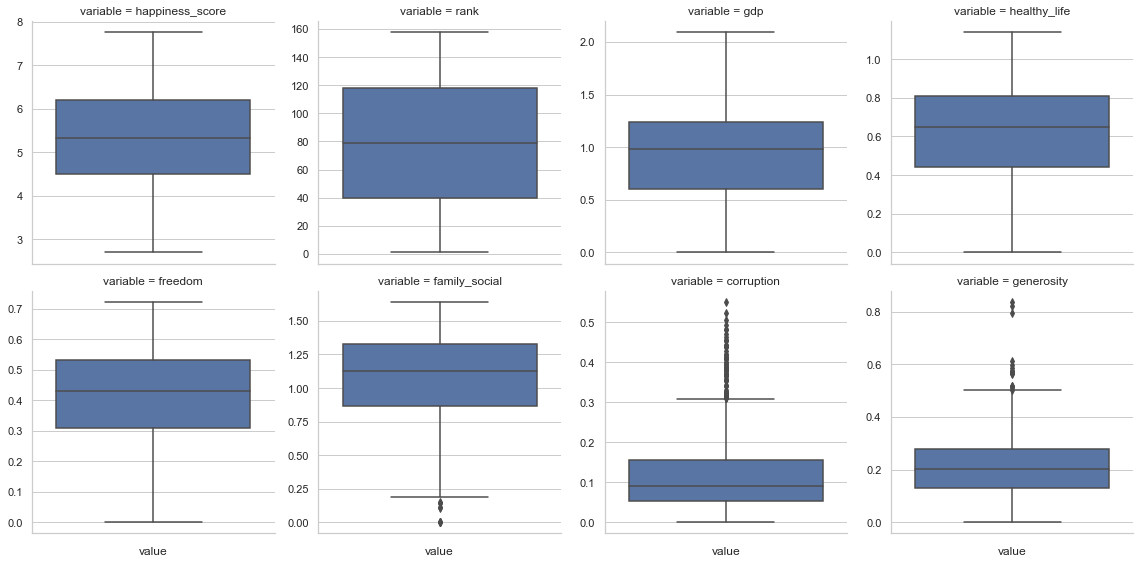

In [36]:
# varsayilan olarak x degeri alan boxplot icin y parametresine deger girildi
def boxplot(y, **kwargs):
    sns.boxplot(y=y)

# melt metodu belli bir sutunu(hedef degisken olabilir bu) id degiskeni yapar(id_vars),
# burada id_vars tanimlanmadigindan df deki id olarak kaldi
# diger sutun(lari) satirlara alt alta ekler(value_vars) ve yeni bir dataframe olusturur
f = pd.melt(happiness, value_vars=continuous)
f
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False, size=4)
g = g.map(boxplot, "value" )

- ```['family_social', 'corruption', 'generosity']``` degerlerinde aykiri degerleri tespit ettik.

---
***Aykiri degerleri giderme***
- ```winsorize``` metodu ile aykiri degerleri giderelim.

In [37]:
# winsorize metodu ile aykiri degerleri giderdik
happiness['winsorize_family_social'] = winsorize(happiness['family_social'], (0.02, 0))
happiness['winsorize_corruption'] = winsorize(happiness['corruption'], (0, 0.09))
happiness['winsorize_generosity'] = winsorize(happiness['generosity'], (0, 0.03))

# winsorize edilmis degiskenler listesi
winsorize = ['winsorize_family_social', 'winsorize_corruption', 'winsorize_generosity']

# winsorize edilmis ve aykiri deger icermeyen surekli degiskenler
winsorize_continuous = ['happiness_score', 'rank', 'gdp', 'healthy_life', 'freedom', 
                        'winsorize_family_social', 'winsorize_corruption', 'winsorize_generosity']

- Boxplot ile wonsorize edilmis degiskenleri inceleyelim.

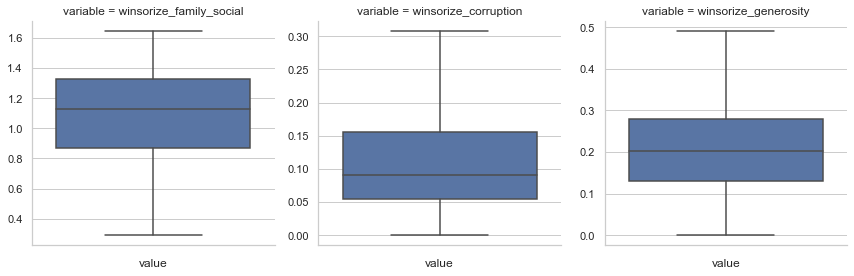

In [38]:
# varsayilan olarak x degeri alan boxplot icin y parametresine deger girildi
def boxplot(y, **kwargs):
    sns.boxplot(y=y)

# melt metodu belli bir sutunu(hedef degisken olabilir bu) id degiskeni yapar(id_vars),
# burada id_vars tanimlanmadigindan df deki id olarak kaldi
# diger sutun(lari) satirlara alt alta ekler(value_vars) ve yeni bir dataframe olusturur
f = pd.melt(happiness, value_vars=winsorize)

g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False, size=4)
g = g.map(boxplot, "value" )

---
## ***Tek degiskenli analiz***

---
***Veri hakkinda genel bilgiler***

In [39]:
print('\nDataframe genel yapisi: \n')
display(happiness.head())
#print('\nDegiskenerin veri tipleri: \n')
#print(house_prices_clean.info())
print('\nTanimlayici istatistikler (Eksik degerler doldurulduktan sonra) :\n')
display(happiness.describe())


Dataframe genel yapisi: 



,country,region,happiness_score,rank,year,gdp,healthy_life,freedom,family_social,corruption,generosity,winsorize_family_social,winsorize_corruption,winsorize_generosity
0,Finland,Western Europe,7.632,1.000,2018,1.305,0.874,0.681,1.592,0.393,0.202,1.592,0.308,0.202
1,Norway,Western Europe,7.594,2.000,2018,1.456,0.861,0.686,1.582,0.340,0.286,1.582,0.308,0.286
2,Denmark,Western Europe,7.555,3.000,2018,1.351,0.868,0.683,1.590,0.408,0.284,1.590,0.308,0.284
3,Iceland,Western Europe,7.495,4.000,2018,1.343,0.914,0.677,1.644,0.138,0.353,1.644,0.138,0.353
4,Switzerland,Western Europe,7.487,5.000,2018,1.420,0.927,0.660,1.549,0.357,0.256,1.549,0.308,0.256



Tanimlayici istatistikler (Eksik degerler doldurulduktan sonra) :



,happiness_score,rank,year,gdp,healthy_life,freedom,family_social,corruption,generosity,winsorize_family_social,winsorize_corruption,winsorize_generosity
count,782.000,782.000,782.000,782.000,782.000,782.000,782.000,782.000,782.000,782.000,782.000,782.000
mean,5.379,78.698,"2,016.994",0.916,0.612,0.411,1.078,0.126,0.219,1.082,0.119,0.216
std,1.127,45.182,1.417,0.407,0.248,0.153,0.330,0.106,0.122,0.320,0.088,0.114
min,2.693,1.000,"2,015.000",0.000,0.000,0.000,0.000,0.000,0.000,0.292,0.000,0.000
25%,4.510,40.000,"2,016.000",0.607,0.440,0.310,0.869,0.054,0.130,0.869,0.054,0.130
50%,5.322,79.000,"2,017.000",0.982,0.647,0.431,1.125,0.091,0.202,1.125,0.091,0.202
75%,6.190,118.000,"2,018.000",1.236,0.808,0.531,1.327,0.156,0.279,1.327,0.156,0.279
max,7.769,158.000,"2,019.000",2.096,1.141,0.724,1.644,0.552,0.838,1.644,0.308,0.491


- winsorize degiskenlerin ugradigi degisiklikleri daha net gorebiliriz.

---
***Dagilimlarin incelenmesi***
- Surekli degiskenler icin dagilimlar incelenir.

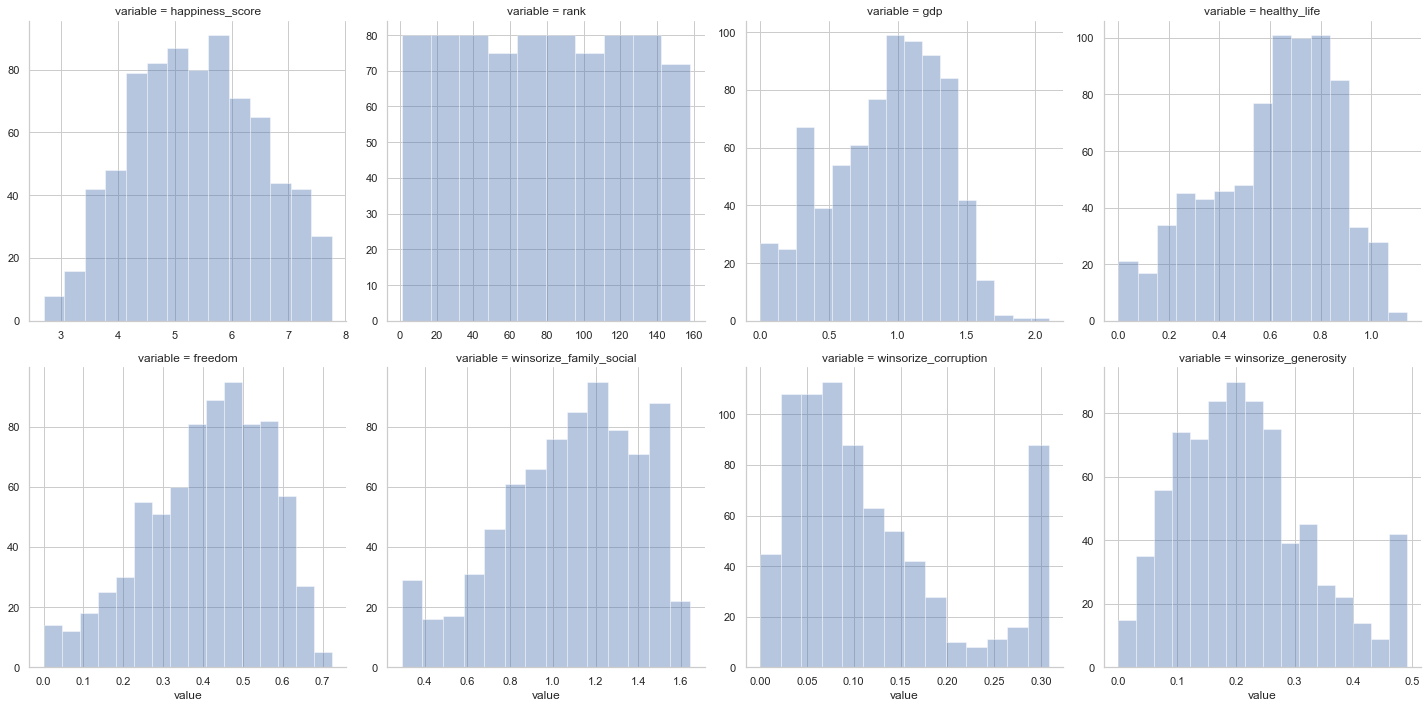

In [40]:
# melt metodu belli bir sutunu(hedef degisken olabilir bu) id degiskeni yapar(id_vars),
# burada id_vars tanimlanmadigindan df deki id olarak kaldi
# diger sutun(lari) satirlara alt alta ekler(value_vars) ve yeni bir dataframe olusturur
f = pd.melt(happiness, value_vars=winsorize_continuous)

g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False, size=5)
g = g.map(sns.distplot, "value", kde=False )

- Winsorize edilmis degiskenlerin onceki ve sonraki dagilimlari incelenir.

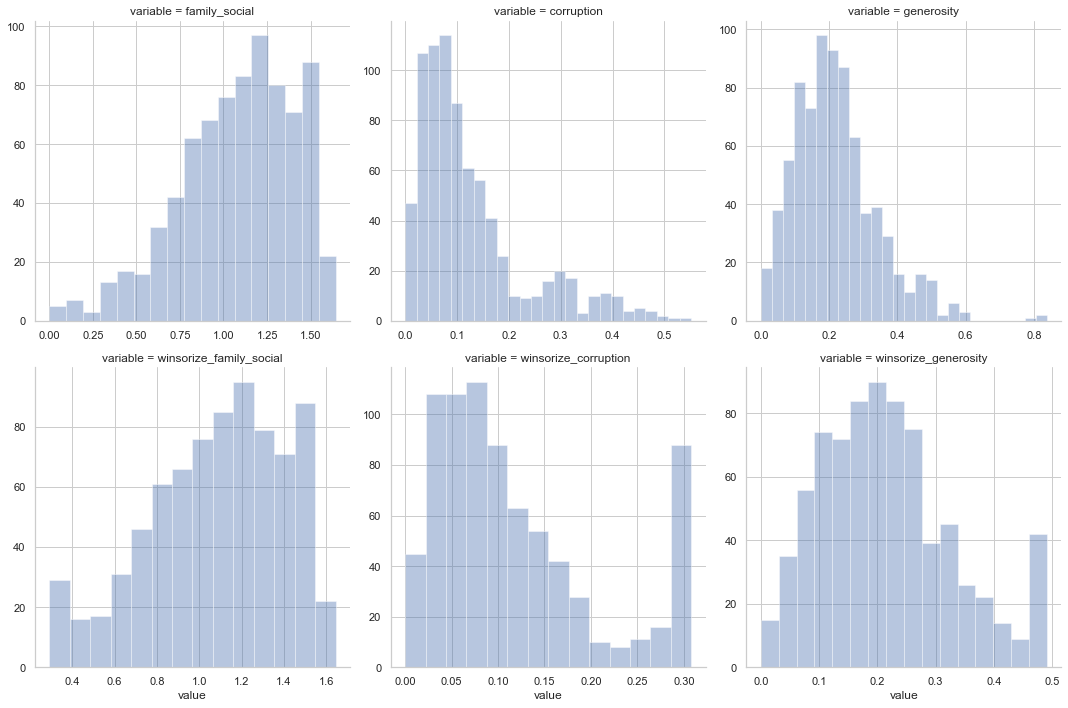

In [41]:
# winsorize edilmis ve edilmemis degiskenler listesi
winsorize_normal = ['family_social', 'corruption', 'generosity',
                    'winsorize_family_social', 'winsorize_corruption', 'winsorize_generosity']
# melt metodu belli bir sutunu(hedef degisken olabilir bu) id degiskeni yapar(id_vars),
# burada id_vars tanimlanmadigindan df deki id olarak kaldi
# diger sutun(lari) satirlara alt alta ekler(value_vars) ve yeni bir dataframe olusturur
f = pd.melt(happiness, value_vars=winsorize_normal)

g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False, size=5)
g = g.map(sns.distplot, "value", kde=False )

- Log alindiktan sonraki dagilim grafikleri.

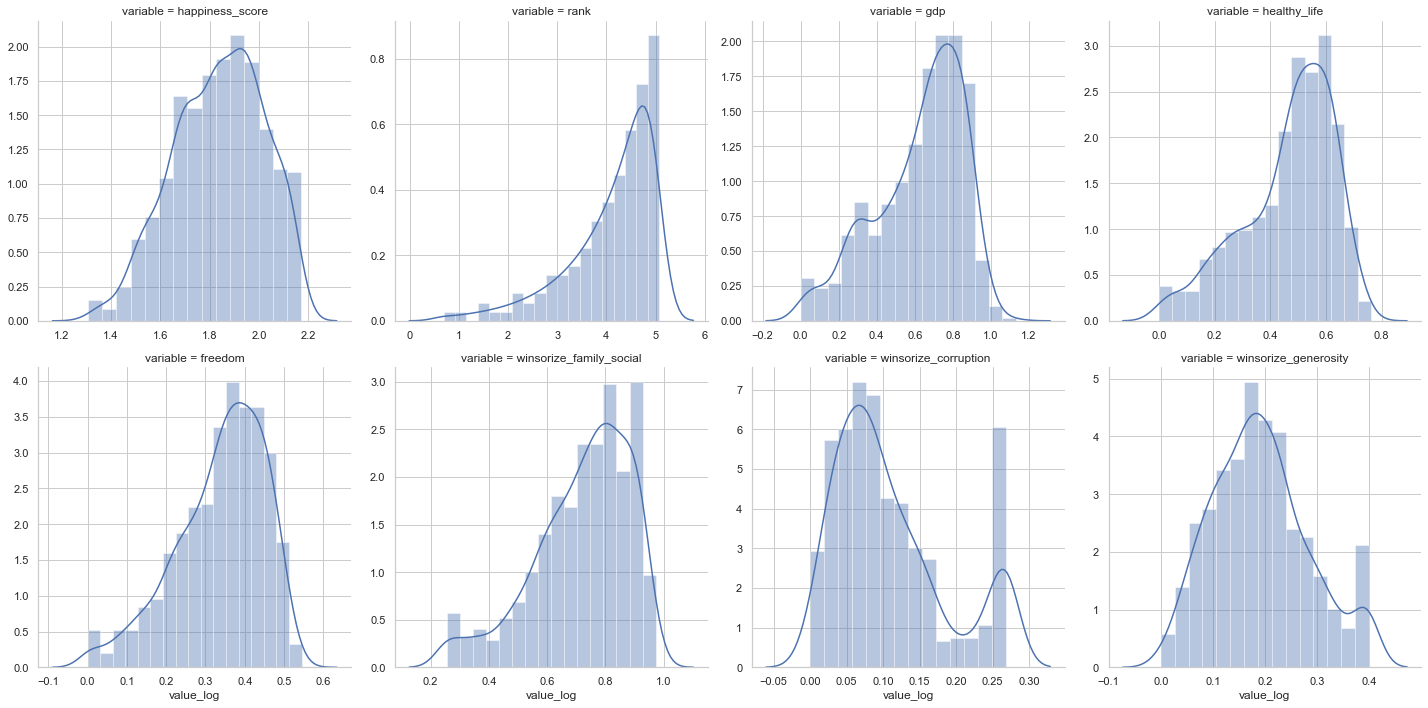

In [42]:
# melt metodu belli bir sutunu(hedef degisken olabilir bu) id degiskeni yapar(id_vars),
# burada id_vars tanimlanmadigindan df deki id olarak kaldi
# diger sutun(lari) satirlara alt alta ekler(value_vars) ve yeni bir dataframe olusturur
f = pd.melt(happiness, value_vars=winsorize_continuous)

# log alindiginde sonsuz hatasi almamak icin arti 1
# degerlerin log alinarak ayri bir sutun olusturuldu
f['value_log'] = np.log(f['value']+1)

g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False, size=5)
# logu alinmis degerler cizdirildi
g = g.map(sns.distplot, "value_log", kde=True )


- Normal dagilima yakin degiskenler mevcut. Ancak tamamen normal dagilim yok.

---
## ***Cok degiskenli analiz***

---
***Surekli-Kategorik degisken analizi***
- Hedef degiskenimiz ```happiness_score```
- Hedef degiskenle (surekli), kategorik degiskenlerimizi bar grafigi ile analiz edebiliriz.

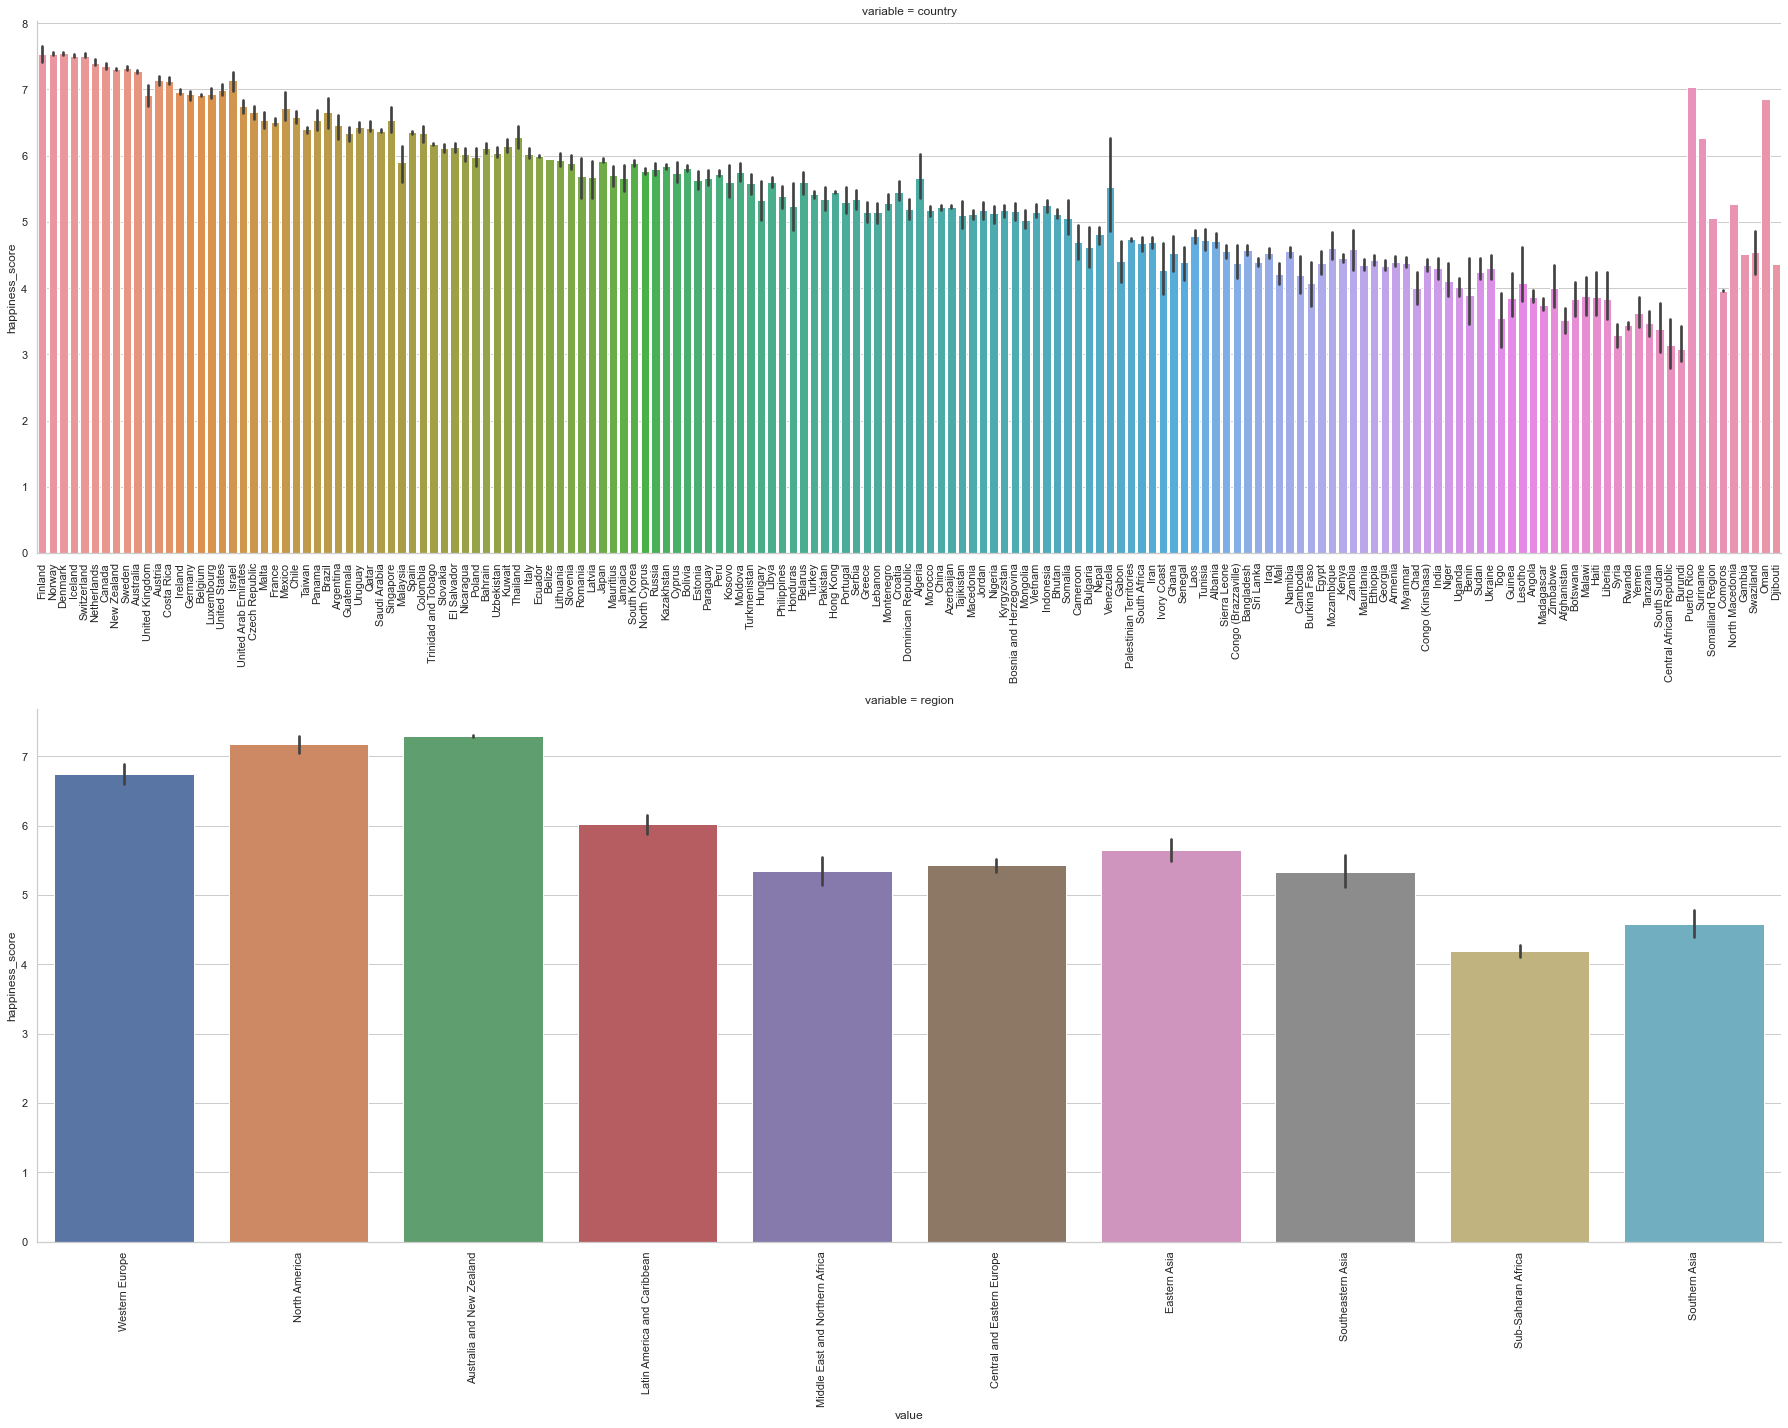

In [43]:
# barplot fonksiyonu tanimlandi
# fonksiyon icnide xticks rotasyon uygulandi 
def barplot(x, y, **kwargs):    
    sns.barplot(x=x, y=y)
    x=plt.xticks(rotation=90)

# melt metodu belli bir sutunu(hedef degisken olabilir bu) id degiskeni yapar(id_vars),
# diger sutun(lari) satirlara alt alta ekler(value_vars) ve yeni bir dataframe olusturur
# boylece hedef degiskenin diger degiskenlerle iliskisini ortaya cikarabiliriz
f = pd.melt(happiness, id_vars=['happiness_score'], value_vars=['country', 'region'])

g = sns.FacetGrid(f, col="variable",  col_wrap=1, sharex=False, sharey=False, height=10, aspect=2.5)
g = g.map(barplot, "value", "happiness_score")

- Sirali olarak barplot.

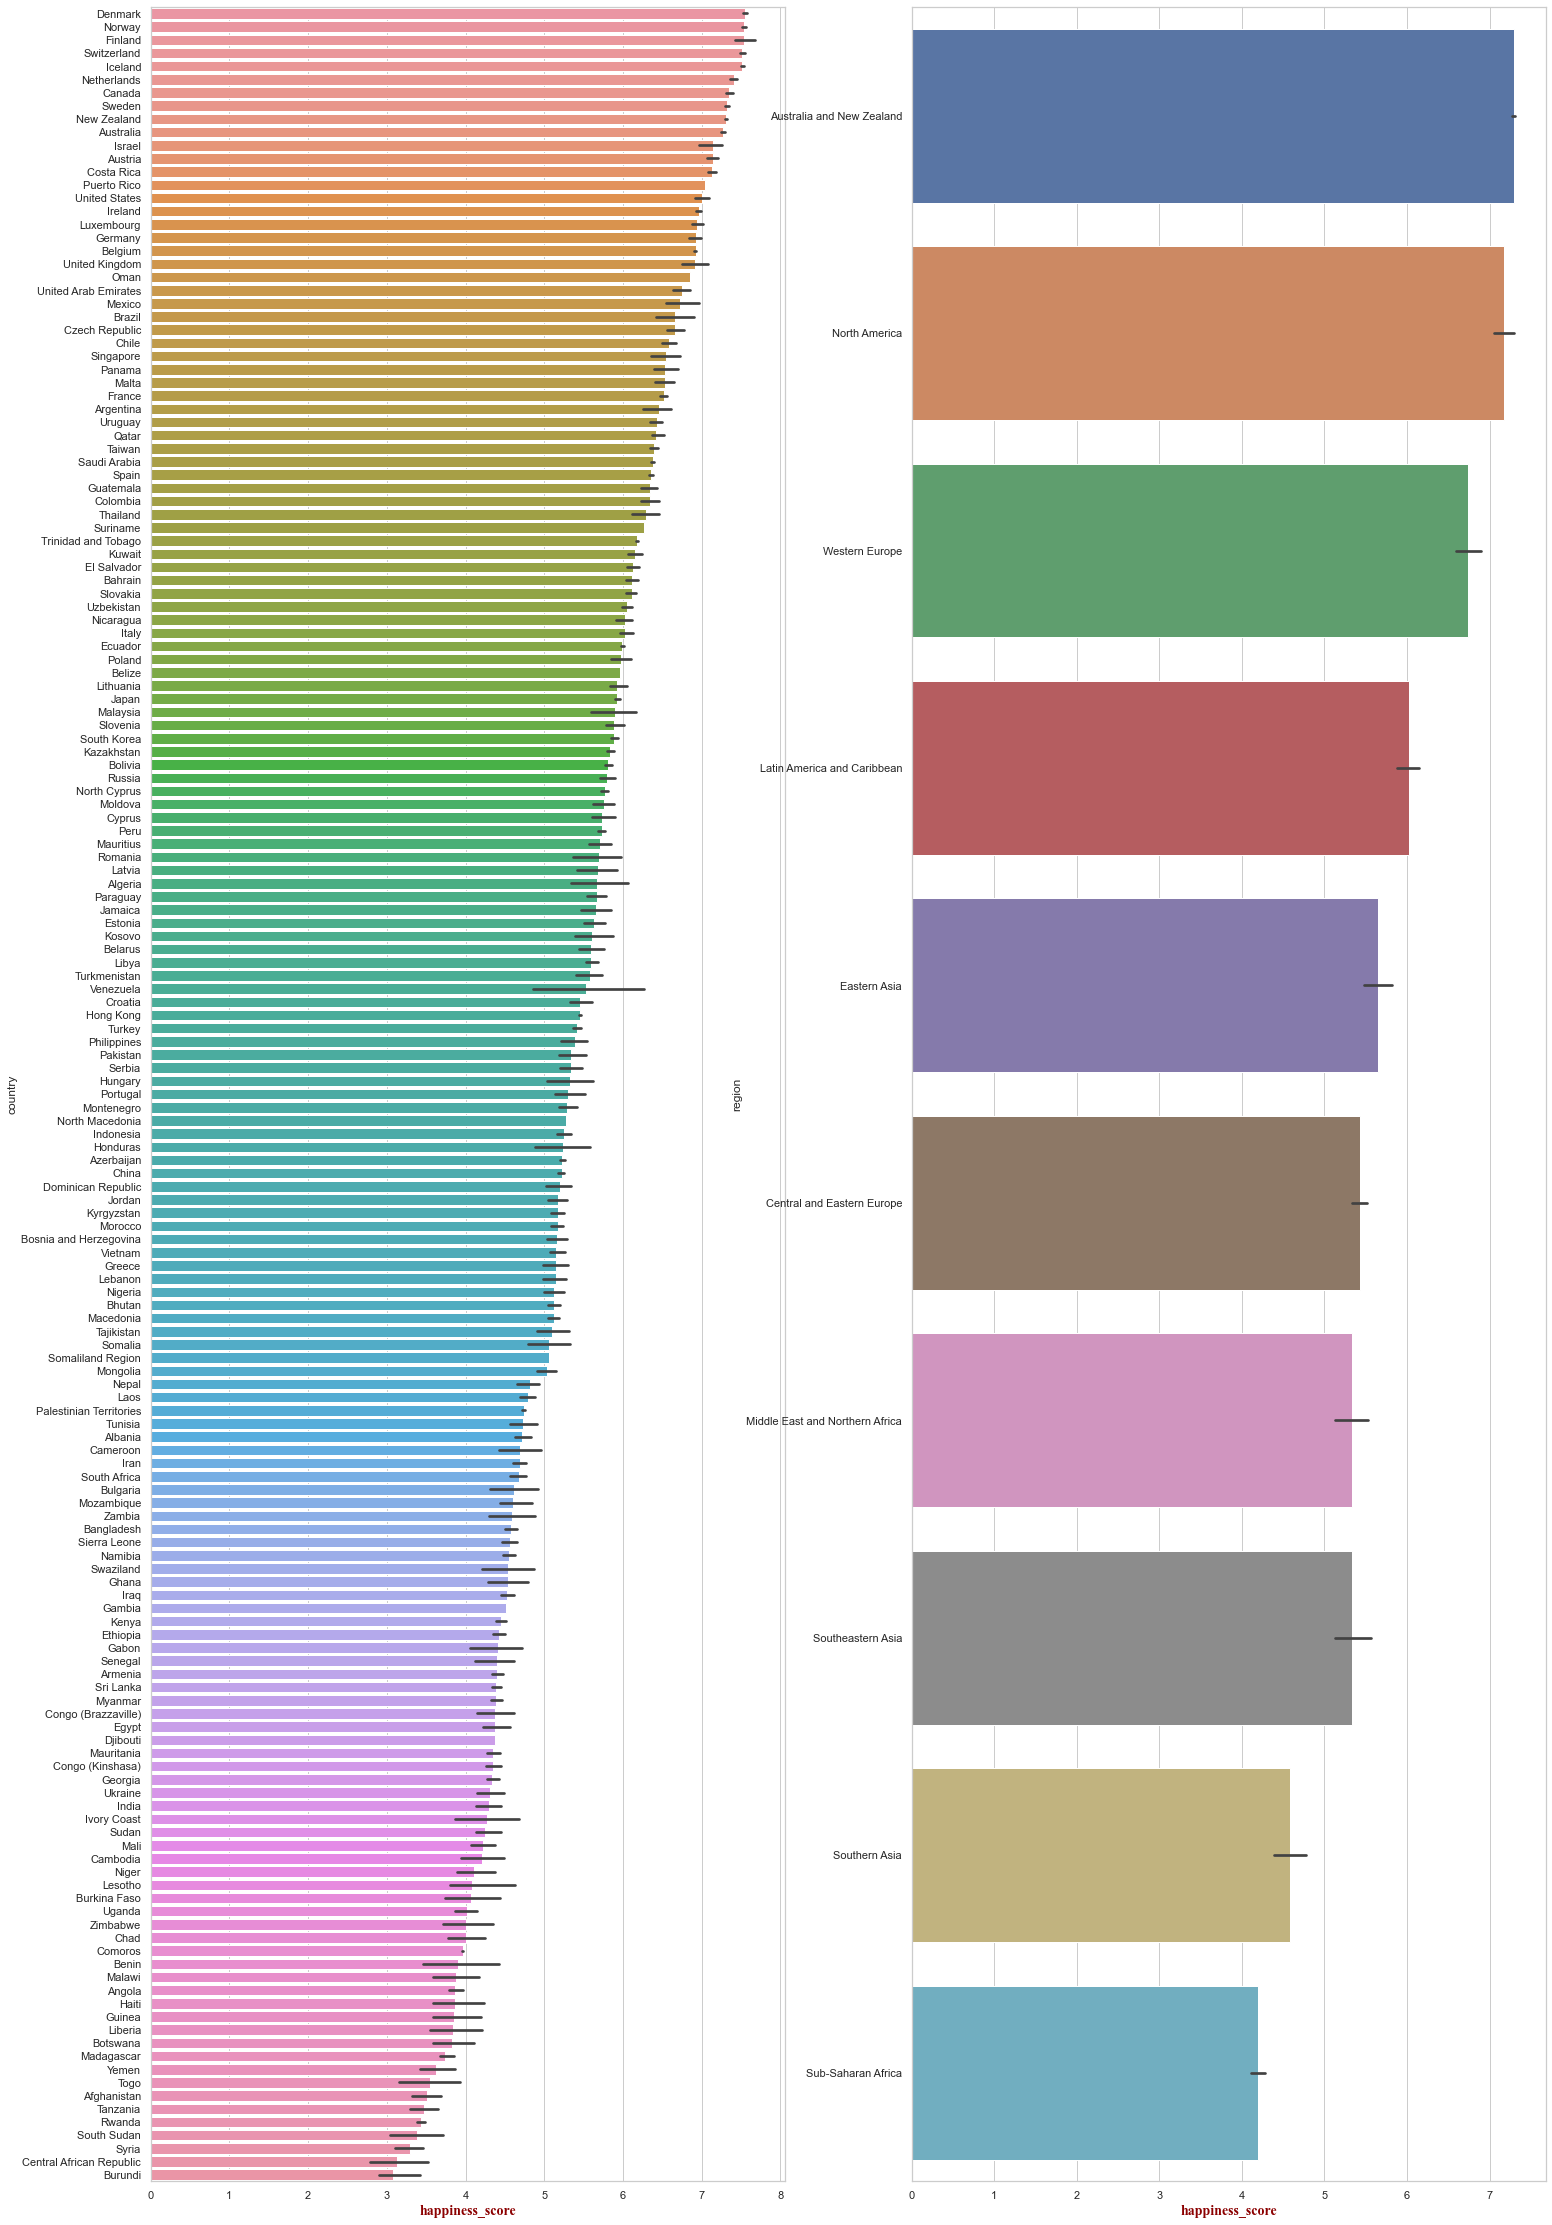

In [60]:
# sirali olarak barplot yapmak icin fonksiyon tanimi
def barplot_ordered(df, categories, target_var, column_n = 1,  **kwargs):
    
    # satir sayisini hesaplama
    row_n = np.ceil(len(categories)/column_n)
    # satir ve sutun sayisindan grafik boyutu hesabi
    plt.figure(figsize=(25 , 40 * row_n ))

    for i,category in enumerate(categories):
        # kategorik degisken degerlerini hedef degisken ortalamasina gore buyukten kucuge sirala
        ordering = df.groupby([category]).mean()[target_var].sort_values(ascending=False)
        plt.subplot(row_n, column_n, i+1)
        # barplot metodunu order parametresi ile siralama yapacak sekilde cagirdik
        sns.barplot(y=df[category], x=df[target_var], order = ordering.index)
        #x=plt.xticks(rotation=90)
        plt.xlabel(target_var, fontdict=axis_font)
    plt.show()
    

    
# hedef degiskenle ve categories listesindeki degiskenler karsilastirilacak
target_var = 'happiness_score'
# cizdirecegimiz kategorik degiskenler
categories=['country', 'region']
# her satir icin cizilecek grafik sayisi
column_n = 2
barplot_ordered(happiness, categories, target_var, column_n)
    

- Sirali ve bolgelerine gore renklendirme icin ```hue``` parametresi eklendi ancak bar garfiginde barlar cok inceldi bunu engellemek icin ```dodge``` parametresi de eklendi.

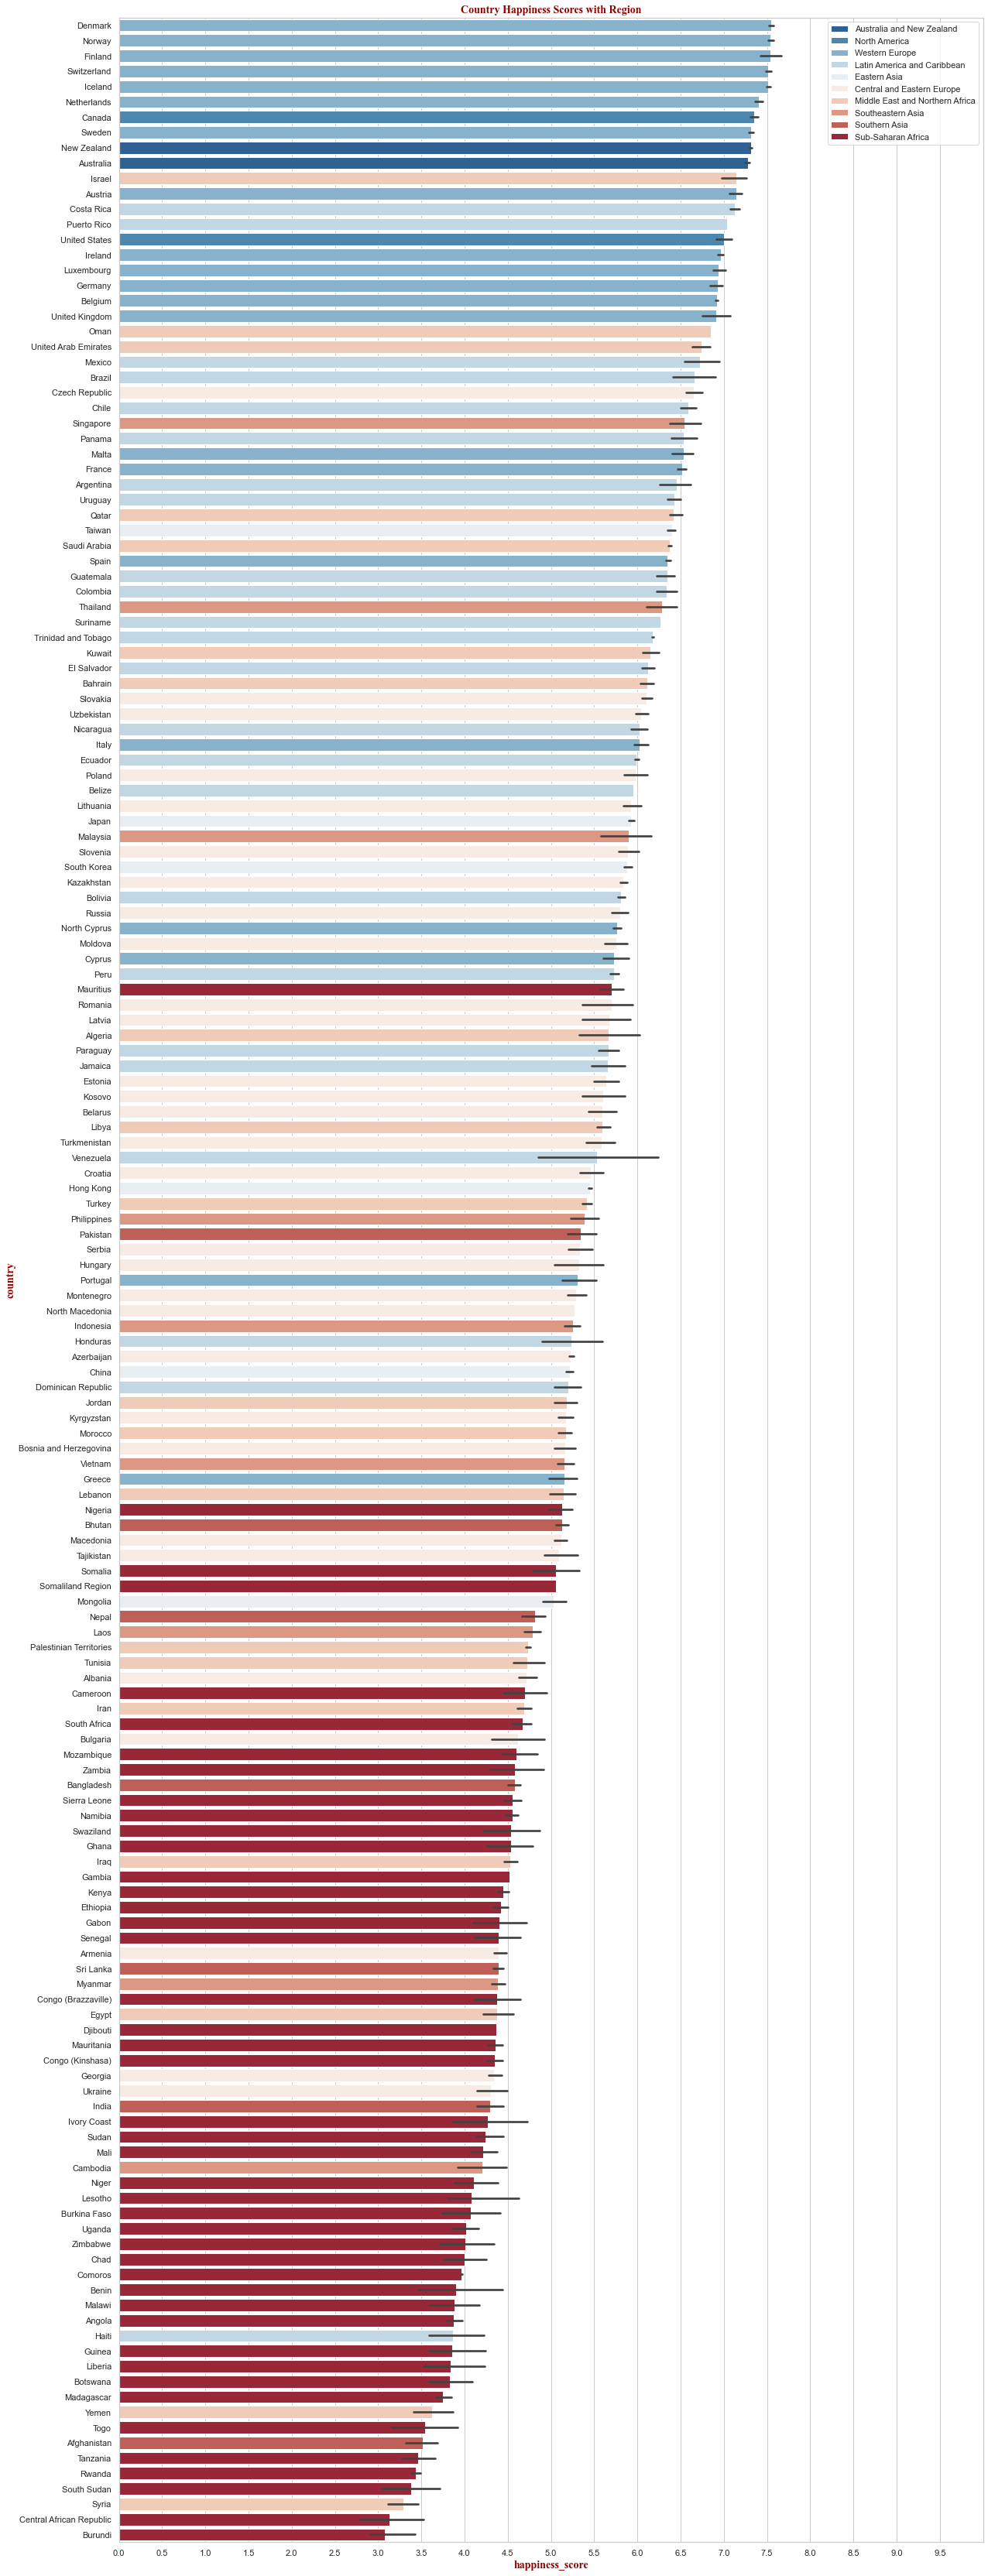

In [89]:
# sirali olarak barplot yapmak icin fonksiyon tanimi
def barplot_ordered_hue(df, categories, hue, target_var, column_n = 1,  **kwargs):
    # hue degisken degerini hedef degisken ortalamasina gore buyukten kucuge sirala
    order_hue = happiness.groupby([hue]).mean()[target_var].sort_values(ascending=False)
    
    # satir sayisini hesaplama
    row_n = np.ceil(len(categories)/column_n)
    # satir ve sutun sayisindan grafik boyutu hesabi
    plt.figure(figsize=(20 , 60 * row_n ))

    for i,category in enumerate(categories):
        plt.title('Country Happiness Scores with Region',fontdict=title_font)
        # kategorik degisken degerlerini hedef degisken ortalamasina gore buyukten kucuge sirala
        order_category = df.groupby([category]).mean()[target_var].sort_values(ascending=False) 
        plt.subplot(row_n, column_n, i+1)
        # barplot metodunu order parametresi ile siralama yapacak sekilde cagirdik
        # hue parametresi girince barlar cok incelmisti onu engellemek icin dodge=False girdik
        sns.barplot(y=df[category], x=df[target_var], hue=df[hue], palette='RdBu_r', 
                    order = order_category.index, hue_order=order_hue.index, dodge=False)
        plt.xticks(np.arange(0,10,0.5))
        plt.xlabel(target_var, fontdict=axis_font)
        plt.ylabel(category, fontdict=axis_font)
        # legend lokasyonunu belirle
        plt.legend(loc=1)
        # legend sigmasi icin limiti artirdik
        plt.xlim(0,10)
    
    plt.show()
    

    
# hedef degiskenle ve categories listesindeki degiskenler karsilastirilacak
target_var = 'happiness_score'
# cizdirecegimiz kategorik degiskenler
categories=['country']
# hue degiskeni
hue='region'
# her satir icin cizilecek grafik sayisi
column_n = 1
barplot_ordered_hue(happiness, categories, hue, target_var, column_n)

- Yuksek mutluluga sahip olanlarin (%75 quantile ve uzeri) region degiskeninin incelenmesi.

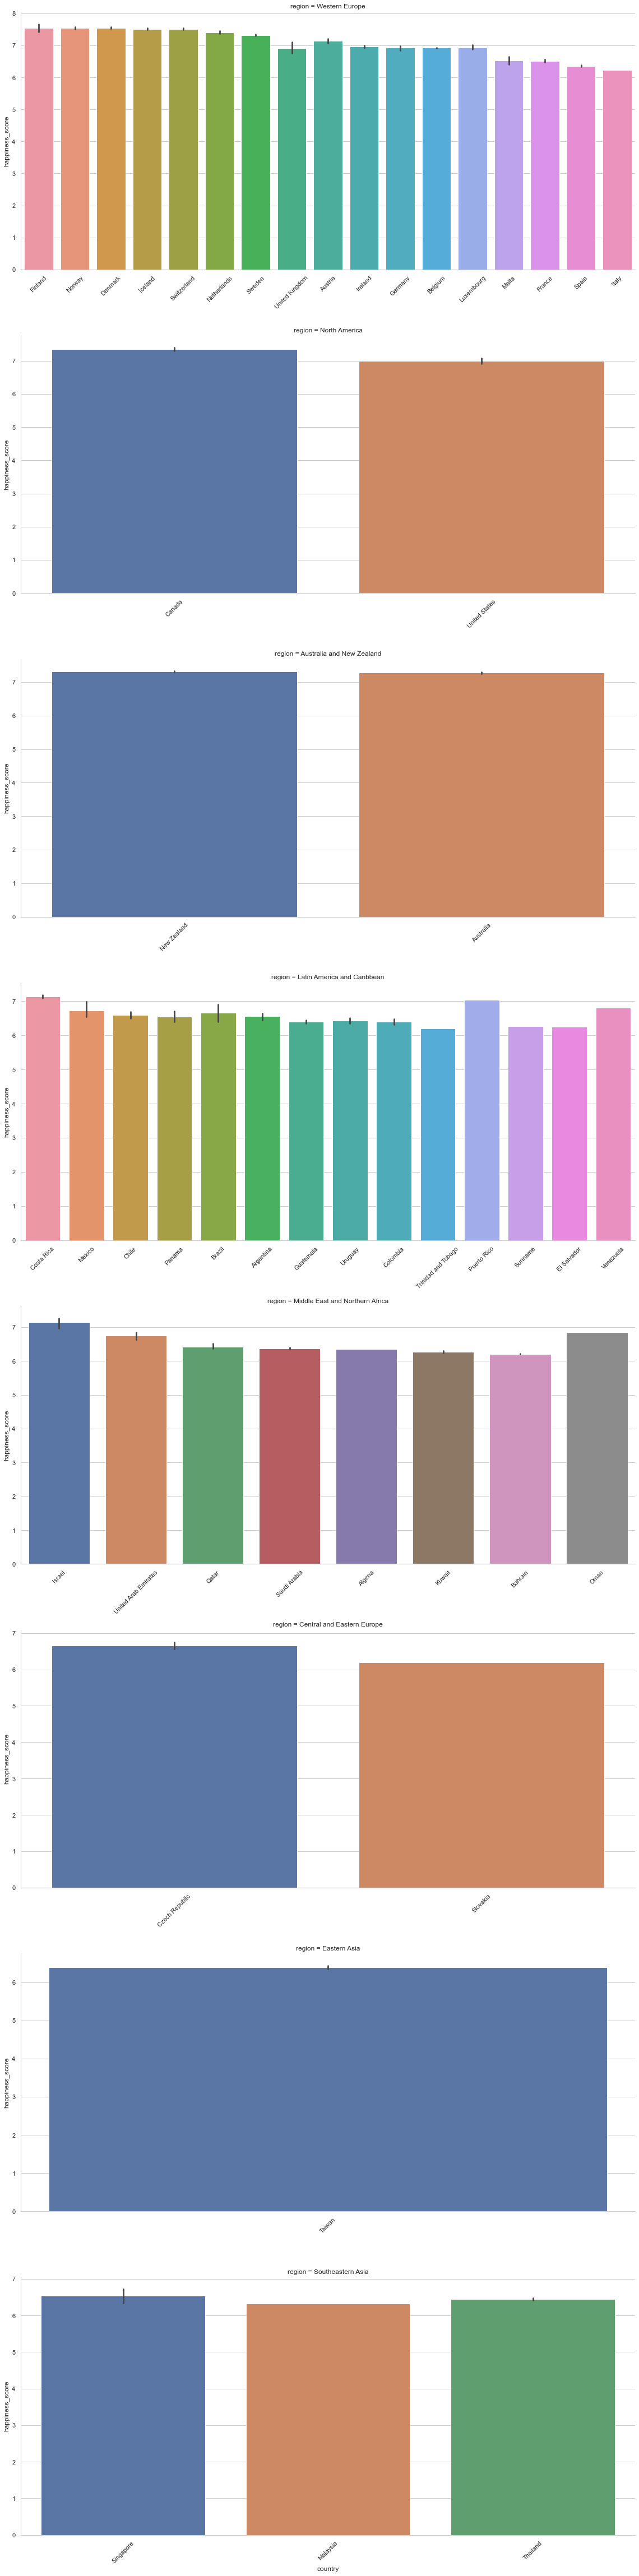

In [45]:
# yuksek mutluluk indeksine sahip df %75 quantile uzeri
high_happiness = happiness.loc[happiness['happiness_score']>=6.19]
# barplot fonksiyonu tanimlandi
# fonksiyon icnide xticks rotasyon uygulandi 
def barplot(x, y, **kwargs):    
    sns.barplot(x=x, y=y)
    x=plt.xticks(rotation=45)

# melt metodu belli bir sutunu(hedef degisken olabilir bu) id degiskeni yapar(id_vars),
# diger sutun(lari) satirlara alt alta ekler(value_vars) ve yeni bir dataframe olusturur
# boylece hedef degiskenin diger degiskenlerle iliskisini ortaya cikarabiliriz
#f = pd.melt(happiness, id_vars=['happiness_score'], value_vars=['country', 'region'])

g = sns.FacetGrid(high_happiness, col="region",  col_wrap=1, sharex=False, sharey=False, height=8, aspect=2)
g = g.map(barplot, "country", "happiness_score")

- Quantile araliklarindaki bolgelerin incelenmesi.

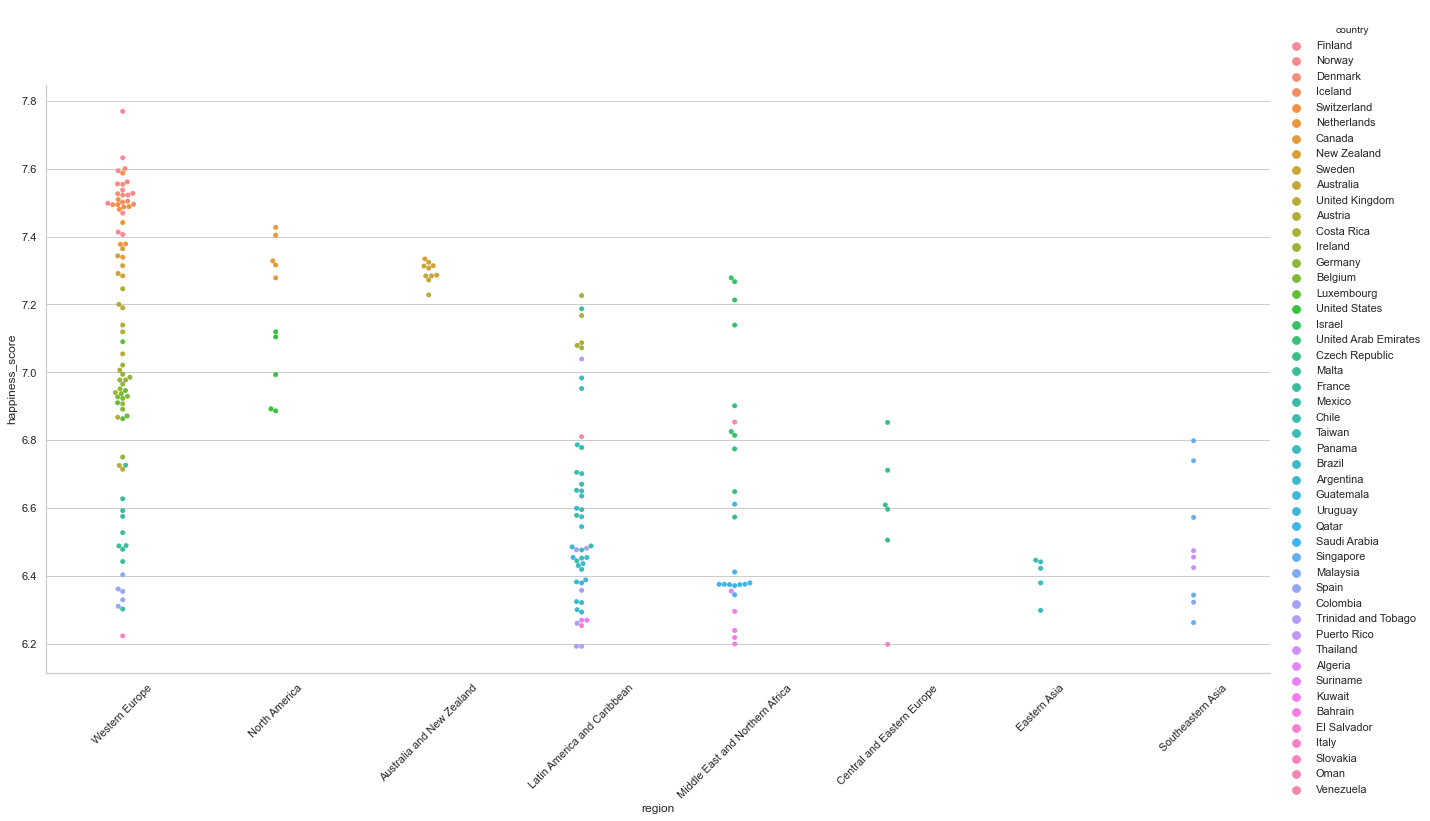

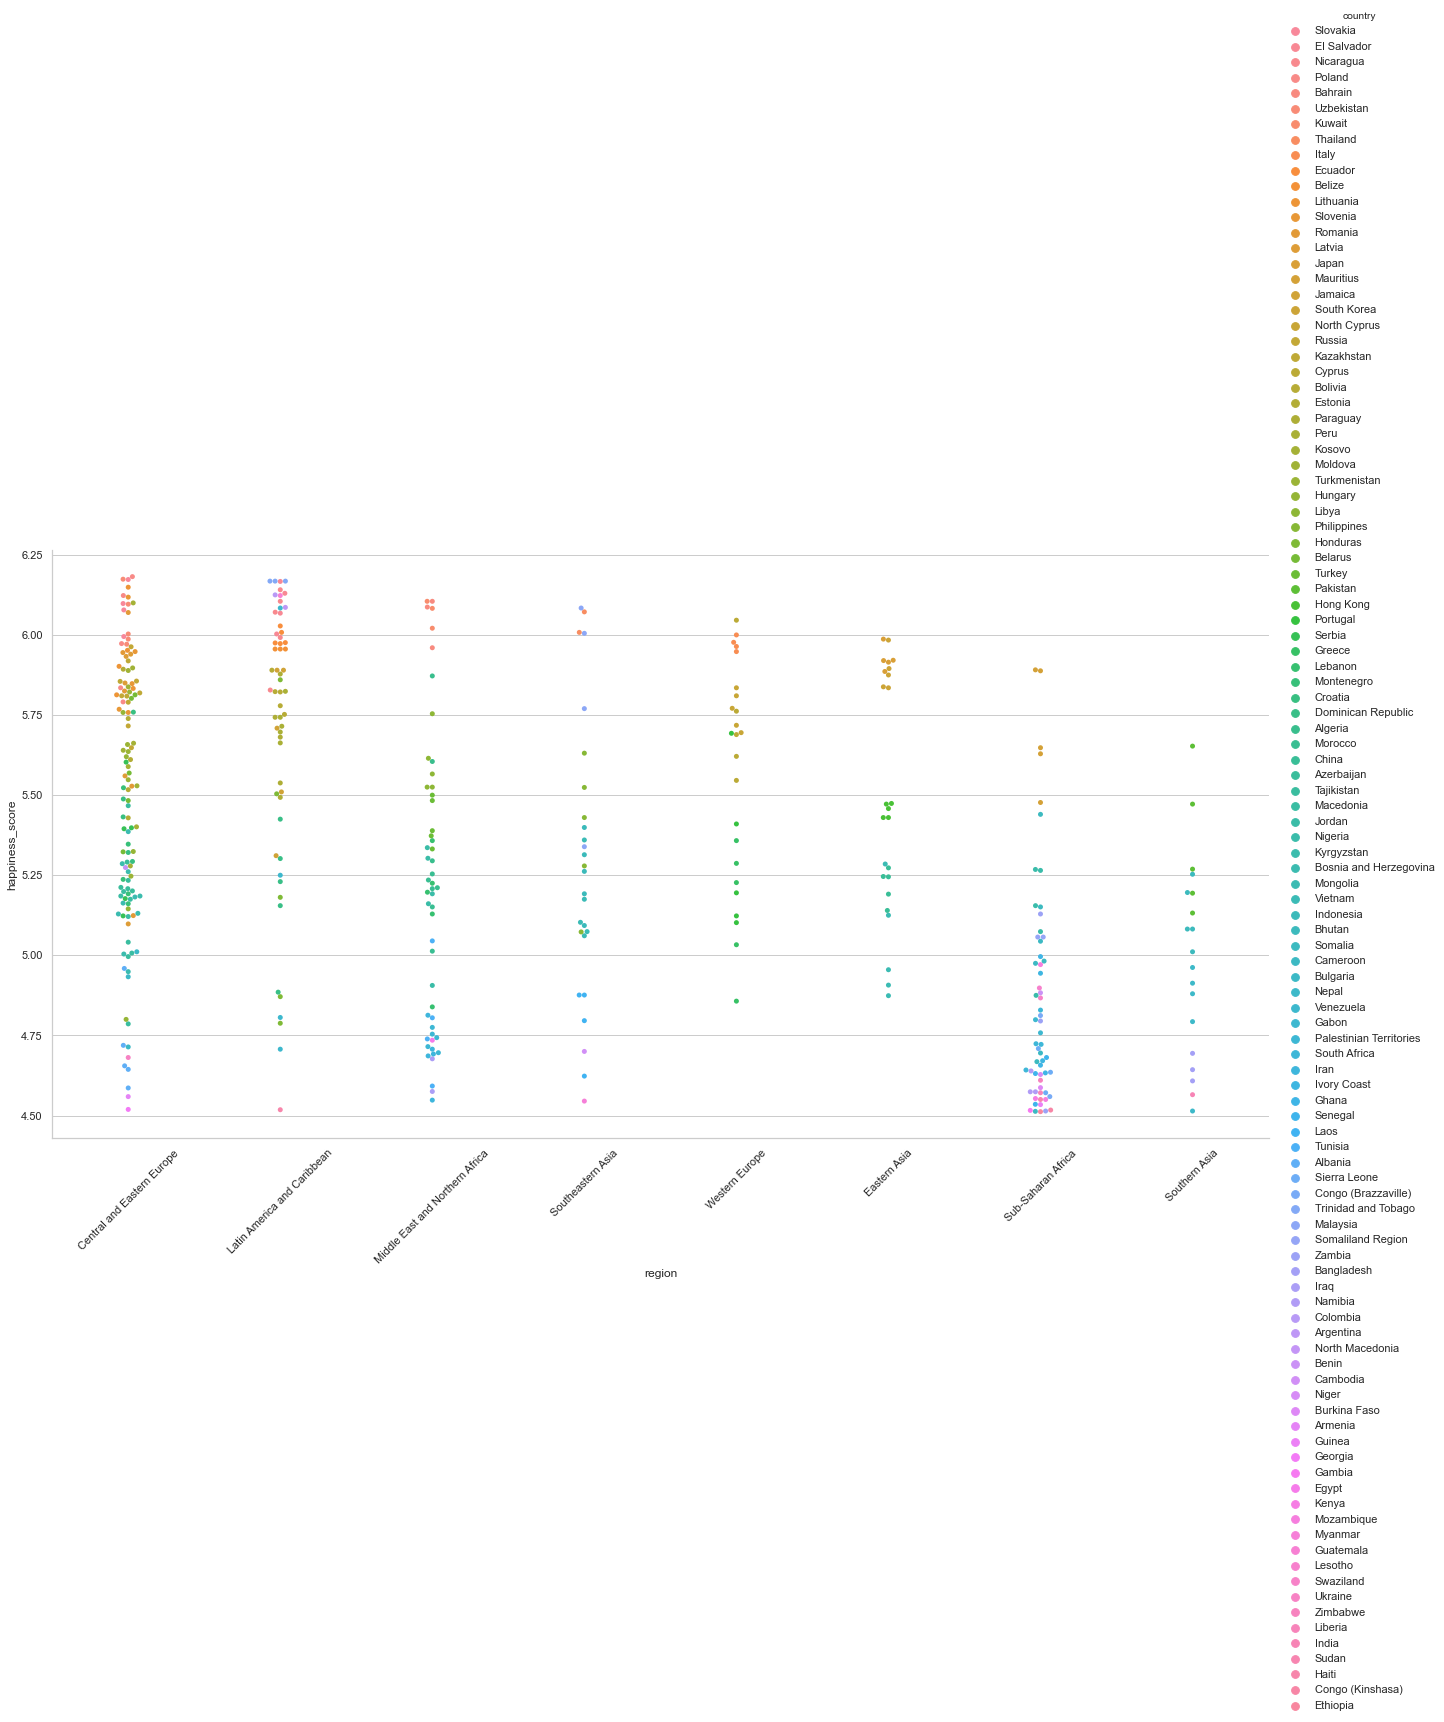

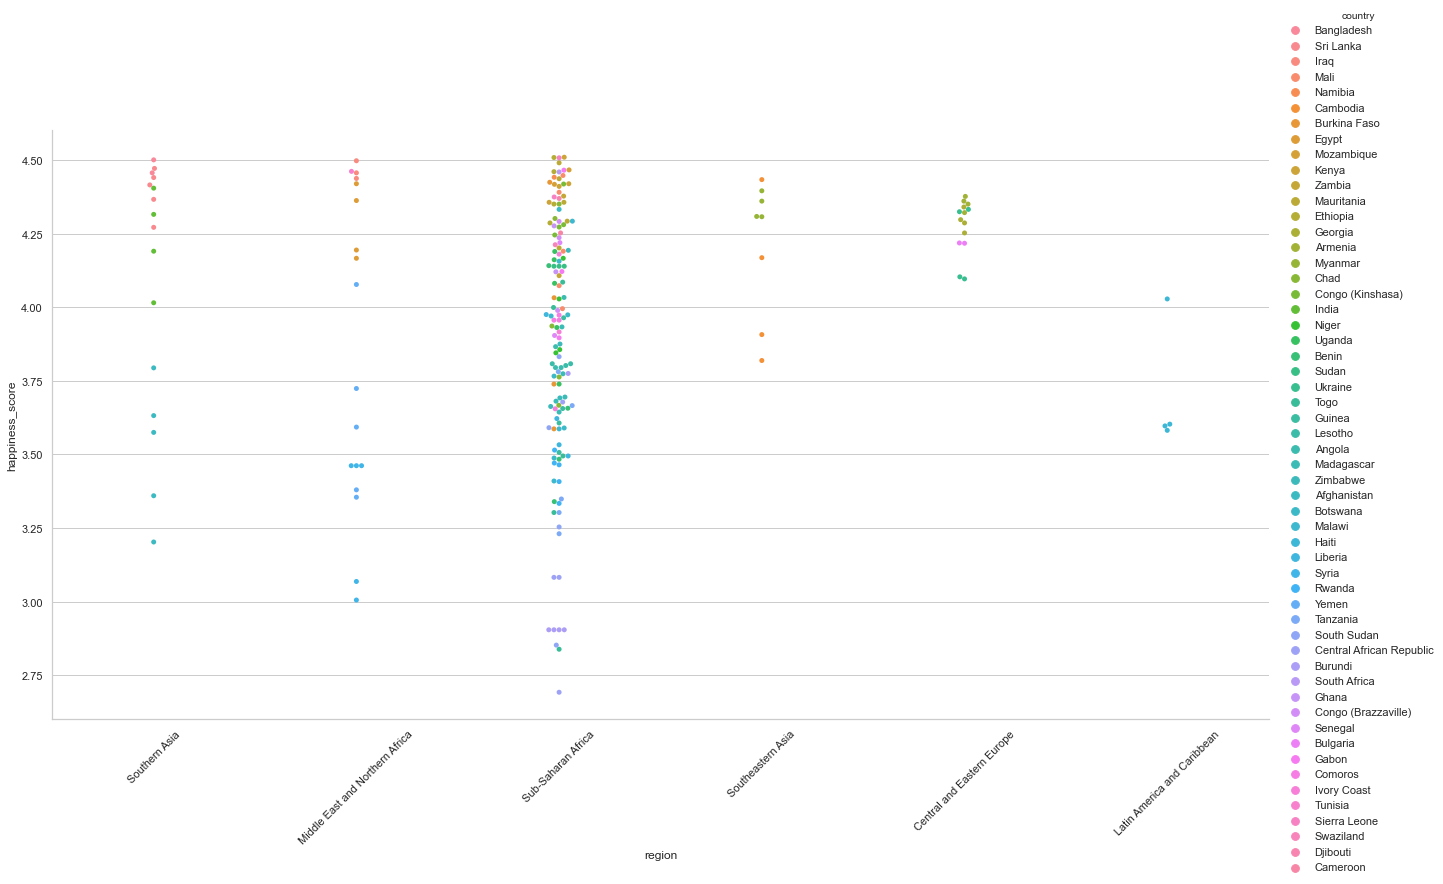

In [110]:
# yuksek mutluluk indeksine sahip df %75 quantile uzeri
high_happiness = happiness.loc[happiness['happiness_score']>=6.19]
# orta seviye mutluluk indeksine sahip %25-75 arasi 
medium_happiness = happiness.loc[(happiness['happiness_score']<6.19) & (happiness['happiness_score']>4.51)]
# dusuk mutluluk indeksine sahip %25 quantile ve alti df
low_happiness = happiness.loc[happiness['happiness_score']<=4.51]

happiness_levels = [high_happiness, medium_happiness, low_happiness]
for i in range(3):
    g = sns.catplot(x='region', y='happiness_score', hue='country', data=happiness_levels[i], 
                kind='swarm', height=9, aspect=2)
    g = plt.xticks(rotation=45)

- Boxplot ile region daki happiness_score dagilimlari.

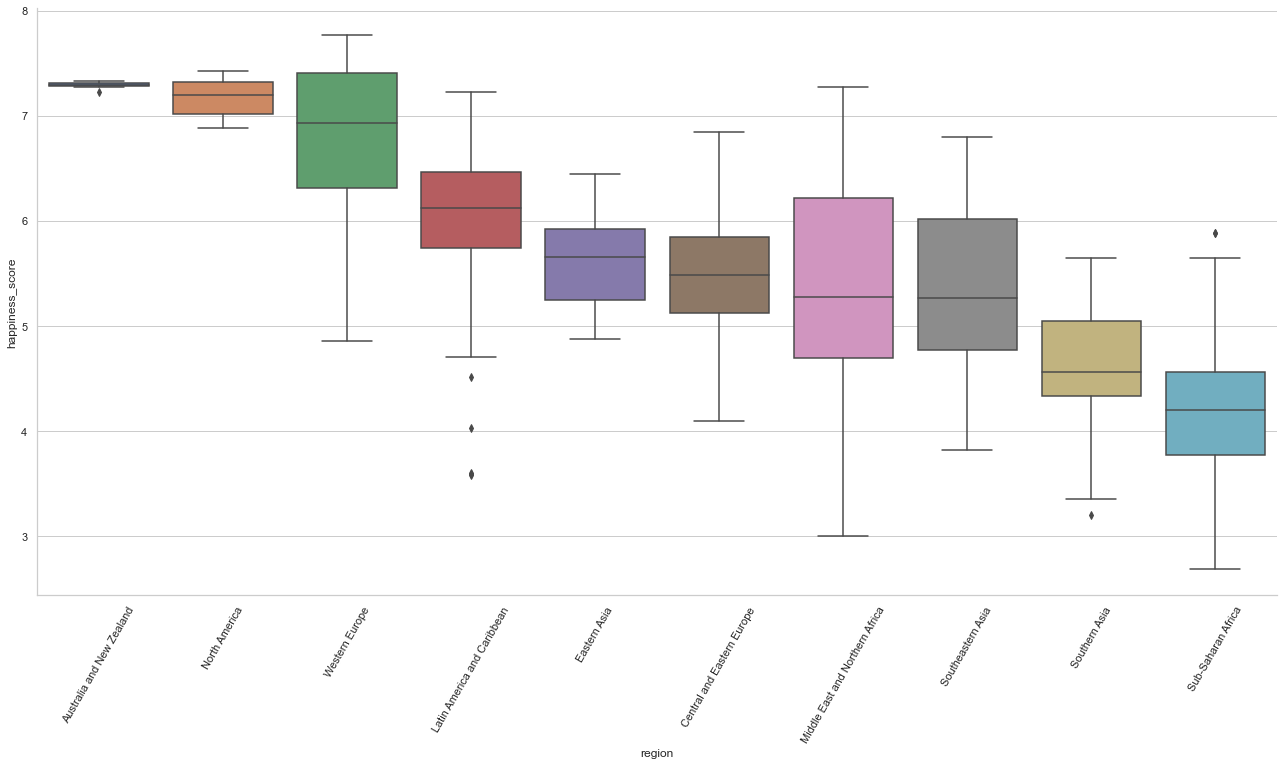

In [47]:
# hedef degisken ortalamalarina gore bolge siralamasi
ordering = happiness.groupby(['region']).mean()['happiness_score'].sort_values(ascending=False)

g = sns.catplot(x='region', y='happiness_score',  data=happiness, order=ordering.index,
                kind='box', height=9, aspect=2)
g = plt.xticks(rotation=60)

---
***Korelasyon***

- Surekli degiskenlerin korelasyonu.

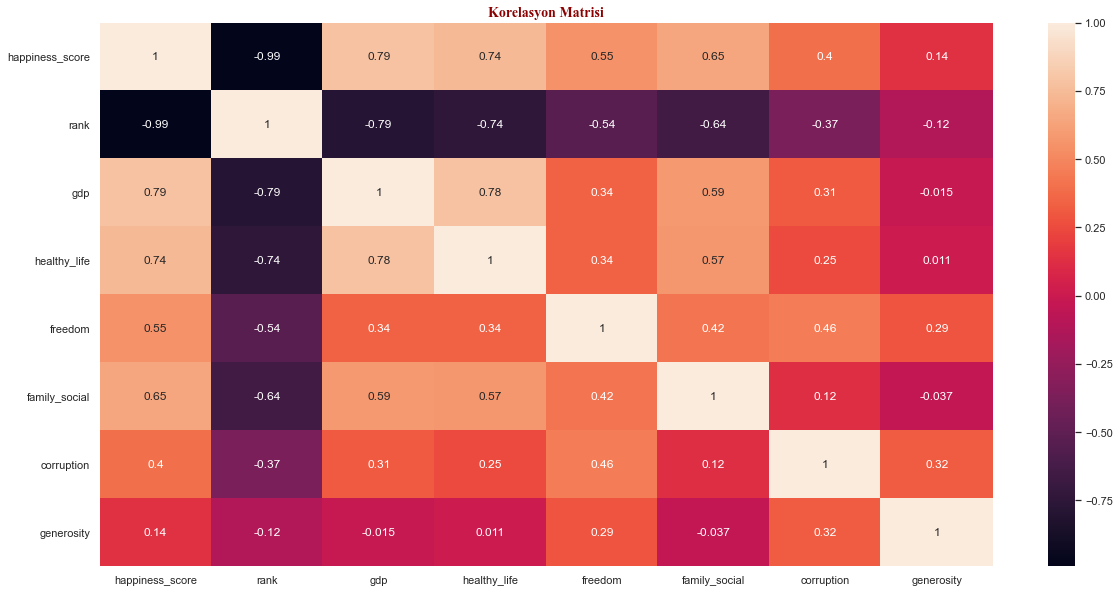

In [48]:
# sadece surekli degiskenlerin oldugu veriler korele edildi
corr_matrix = happiness[continuous].corr()

plt.figure(figsize=(20,10))
sns.heatmap(corr_matrix, annot=True)
plt.title("Korelasyon Matrisi", fontdict=title_font)
plt.show()

- Korelasyonu en yuksek olanlar sirasiyla ```['rank', 'gdp', 'healthy_life', 'family_social']```
- Hedef degiskene gore korelasyon degerleri grafigini inceleyelim.

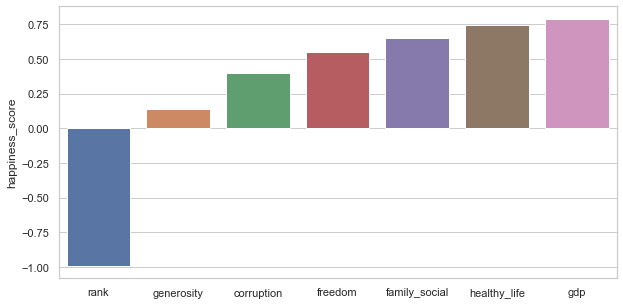

In [49]:
# sadece hedef degiskenin oldugu bolumu matristen aldik
happiness_corr = corr_matrix['happiness_score'].sort_values()
# hedef degiskenimizi cikardik
happiness_corr.drop('happiness_score', inplace= True)

plt.figure(figsize=(10,5))
#plt.bar(x=sale_price_corr.index, height=sale_price_corr)
sns.barplot(x=happiness_corr.index, y=happiness_corr)
plt.show()

- En cok korele olan degiskenlerin hedef degisken ile iliskisini scatterplot ile inceleyelim.

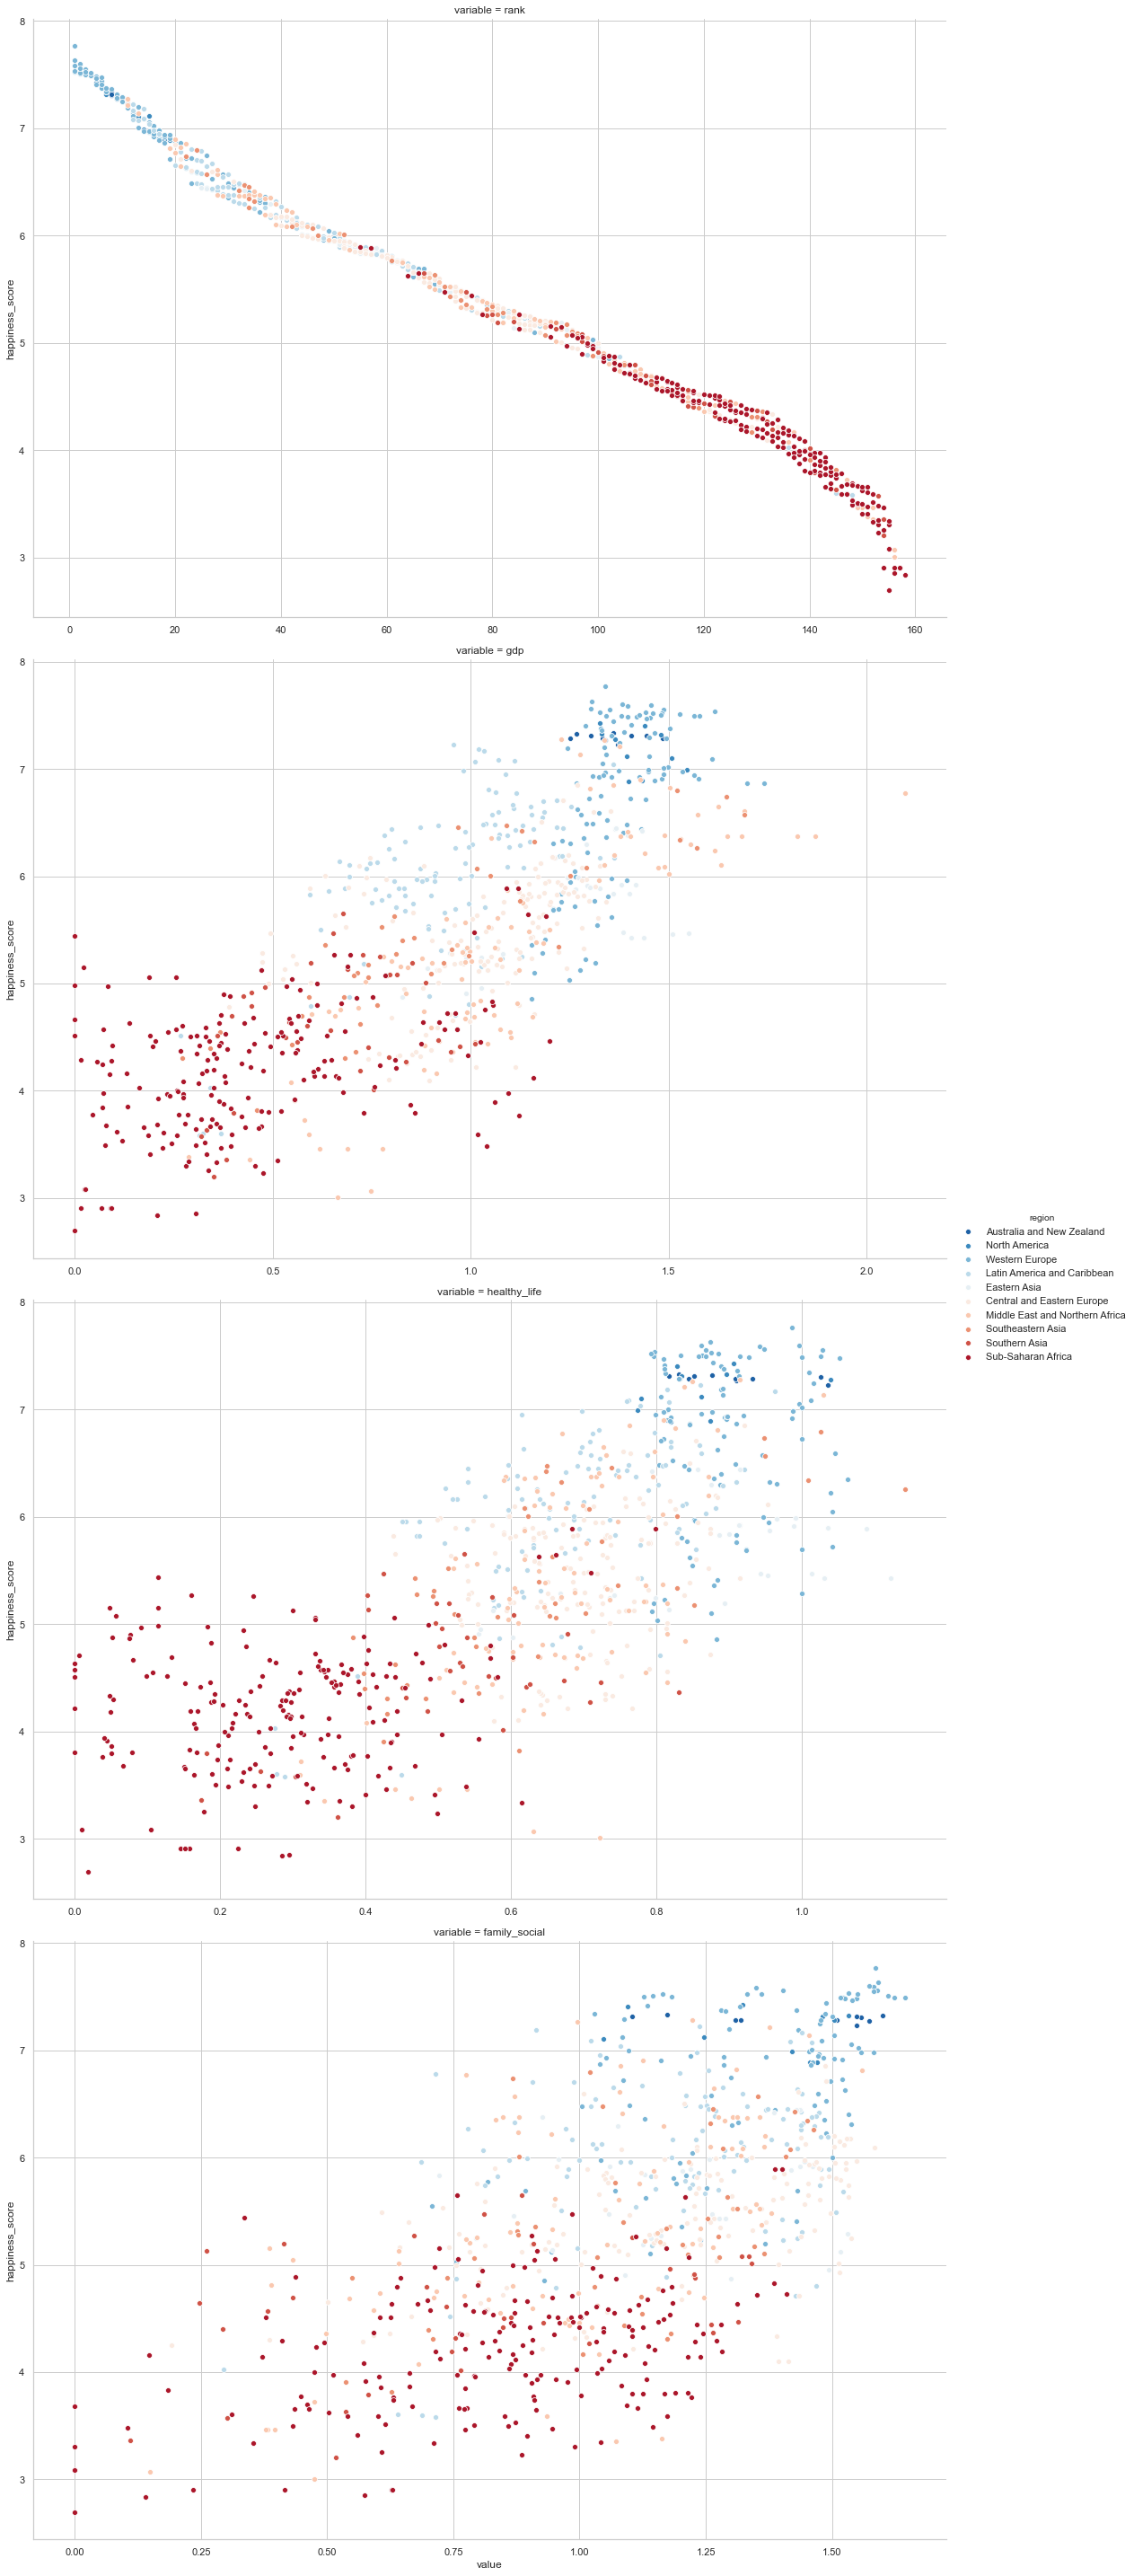

In [90]:
# melt metodu belli bir sutunu(hedef degisken olabilir bu) id degiskeni yapar(id_vars),
# diger sutun(lari) satirlara alt alta ekler(value_vars) ve yeni bir dataframe olusturur
# boylece hedef degiskenin diger degiskenlerle iliskisini ortaya cikarabiliriz
f = pd.melt(happiness, id_vars=['happiness_score', 'region'], 
            value_vars=['rank', 'gdp', 'healthy_life', 'family_social'])

ordering = happiness.groupby(['region']).mean()['happiness_score'].sort_values(ascending=False)

g = sns.FacetGrid(f, col='variable', hue='region', hue_order=ordering.index, col_wrap=1, 
                  sharex=False, sharey=False, height=10, aspect=1.5, palette='RdBu_r')
g = g.map(sns.scatterplot, 'value', 'happiness_score')
g = g.add_legend()

---
## ***Ozellik Muhendisligi***
---
***Temel Bilesenler Analizi (Principal Components Analysis - PCA)***

- Ozvektorler, ozdegerler ve scree grafigi.

In [51]:
# hedef degiskeni surekli degiskenlerden cikardik
winsorize_continuous.remove('happiness_score')
winsorize_continuous

['rank',
 'gdp',
 'healthy_life',
 'freedom',
 'winsorize_family_social',
 'winsorize_corruption',
 'winsorize_generosity']

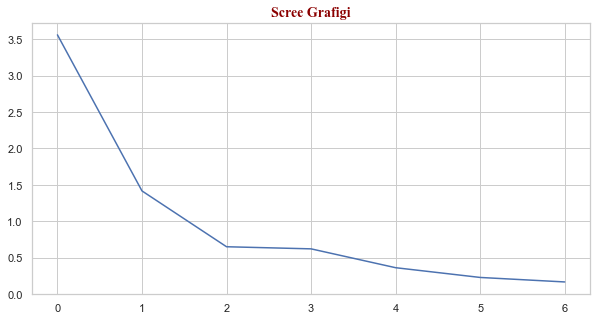

Ozdegerler Matrisi:
[3.56034232 1.41721285 0.65064398 0.62164487 0.36285564 0.22902658
 0.16723662]


In [52]:
### covariance matrix
# dataframe den gerekli sutunlar alinir (surekli degerler)
happiness_pca = happiness[winsorize_continuous]

# veriler X matrisine aktarilir
X = StandardScaler().fit_transform(happiness_pca)

# X in transpozu alinir
Xt = X.T

# covariance matrisi hesaplanir
Cx = np.cov(Xt)
#print('Kovaryans matrisi :\n', Cx)

### eigenvectors and eigenvalues
# covariance matrisinden ozvektorler ve ozdegerler hesaplanir
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

plt.figure(figsize=(10,5))
plt.title('Scree Grafigi', fontdict=title_font)
plt.plot(-np.sort(-eig_val_cov))

plt.show()
print('Ozdegerler Matrisi:')
print(-np.sort(-eig_val_cov))

- Kayşat grafiğine ve özdeğerler > 1 kuralına gore, ilk 2 bileşeni tutmamız gerekir.
- scikit-learn'deki PCA fonksiyonunu kullanarak temel bilesenleri olusturulacagiz.

Veri kümesindeki toplam varyans yüzdesi:
 [0.50796992 0.20220008 0.09283028]


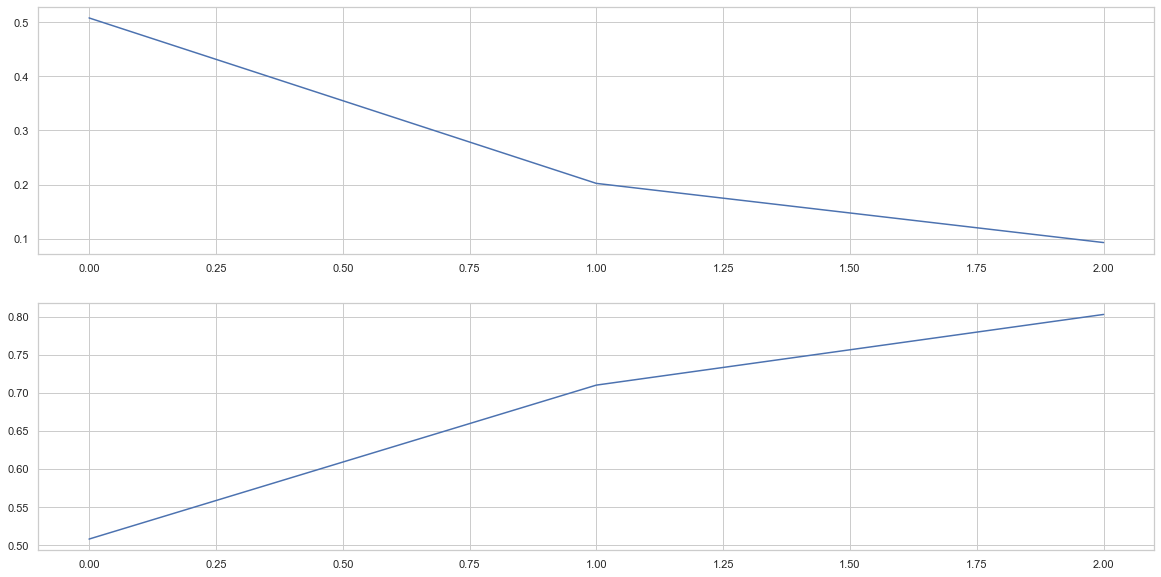

In [53]:
# sklearn yontemi
# kac bilesen seciyorsak PCA metoduna parametre olarak giriyoruz
# ya da aciklanabilecek varyans yuzdesi paramatre olarak girilebilir
# sklearn_pca = PCA(n_components=70)
sklearn_pca = PCA(n_components=3)
Y_sklearn = sklearn_pca.fit_transform(X)
print('Veri kümesindeki toplam varyans yüzdesi:\n',sklearn_pca.explained_variance_ratio_)

plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(sklearn_pca.explained_variance_ratio_)
plt.subplot(212)
plt.plot(np.cumsum(sklearn_pca.explained_variance_ratio_))
plt.show()

In [54]:
sklearn_pca.explained_variance_ratio_.sum()

0.8030002818327862

- Temel Bileşenler Analizi (PCA) uygulandiktan sonra toplam varyansın %80'i ilk 3 bileşen tarafından açıklanabilmektedir.